# Methods

In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import multiprocessing as mp
import numpy as np
import pandas as pd
import pickle
import h5py
from IPython.display import display, Math

from scipy.integrate import trapz, cumtrapz, quad
from scipy.interpolate import UnivariateSpline
from scipy.stats import lognorm, norm, truncnorm, rv_continuous

import astropy.constants as const
import astropy.units as u
import astropy.uncertainty as unc
from astropy.cosmology import WMAP9, z_at_value
from astropy.modeling.functional_models import Linear1D, Const1D, Shift, Gaussian1D
from astropy.modeling.tabular import Tabular1D

from tqdm.autonotebook import tqdm

from src.models.agn_proxy import (Hopkins2007QuasarFormationDensity,
                                  LogNormal1D, Const3D, QuasarProxyBinaries, Hopkins2007QuasarFormationDensity,
                                  ModifiedSchechter, Marconi2004BHMF, Hopkins2007QuasarNumberDensity,
                                  Goulding2019J1010Binaries)
from src.models.major_merger import (Schechter1D, Schechter2D,
                                     DoubleSchechter2D, TripleSchechter2D,
                                     PairFraction3D, PairFraction3D_3bins,
                                     Timescale3D, Sesana2013_Schechter,
                                     Sesana2013_DoubleSchechter,
                                     Sesana2013_TripleSchechter,
                                     Sesana2013_Schechter_Gal_Merge,
                                     Sesana2013_DoubleSchechter_Gal_Merge,
                                     Sesana2013_TripleSchechter_Gal_Merge)

<ipython-input-1-2ba9c2bf64a9>:30: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Global variables
n_samples = int(2 ** 10)
n_mesh = int(2 ** 5)
n_samples, n_mesh

(1024, 32)

In [3]:
# class declarations
class split_normal(rv_continuous):
    def __init__(self, loc, scale1, scale2, *args, **kwargs):
        self.loc = loc
        self.scale1 = scale1
        self.scale2 = scale2
        self.normalization = 2 / (scale1 + scale2)
        super().__init__(self, *args, **kwargs)
        
    def _pdf(self, x):
        if x < self.loc:
            return self.normalization * norm.pdf(x, loc=self.loc, scale=self.scale1)
        else:
            return self.normalization * norm.pdf(x, loc=self.loc, scale=self.scale2)
    
#     def _cdf(self, x):
#         if x < self.loc:
#             return self.normalization * self.scale1 * norm.cdf(x, loc=self.loc, scale=self.scale1)
#         else:
#             return 1 - self.normalization * self.scale2 * (1 - norm.cdf(x, loc=self.loc, scale=self.scale2))
    
    def _ppf(self, q):
        output = np.where(q <= .5,
                          self.loc + self.scale1 * norm.ppf(q),
                          self.loc + self.scale2 * norm.ppf(q))
        return np.squeeze(output)

In [4]:
def trunc_norm_dist(a=0, b=np.inf, loc=0, scale=1, size=n_samples):
    return truncnorm.rvs(a=(a - loc) / scale, b=(b - loc) / scale,
                                          loc=loc, scale=scale,
                                          size=size)

## Dependencies/Assumptions

### Shared

#### Parameter space

In [5]:
log_m_bh_min = 7  # 6 + (1 / 5) * (3 * np.log10(.25) - np.log10(1 + .25))
log_m_bh_max = 10

log_m_bh_range = np.linspace(log_m_bh_min, log_m_bh_max, num=n_mesh)

z_min = 0
z_max = 3
z_range = np.linspace(z_min, z_max, num=n_mesh)

q_min = 0.25
q_max = 1
q_range = np.linspace(q_min, q_max, num=n_mesh)

#### Fiducial values

In [6]:
fidhz = (1 / u.yr).to(u.Hz)

In [7]:
# Calculate the standard deviation from the quoted NANOGrav 5-95% interval
NANOGrav_strain95 = 2.67e-15
NANOGrav_strain05 = 1.37e-15

NANOGrav_log_std = (np.log10(NANOGrav_strain95) - np.log10(NANOGrav_strain05)) / (norm.ppf(.95) - norm.ppf(.05))

In [8]:
# Calculate the standard deviation from the quoted NANOGrav 5-95% interval
IPTA_strain95 = 4e-15
IPTA_strain05 = 2e-15

IPTA_log_std = (np.log10(IPTA_strain95) - np.log10(IPTA_strain05)) / (norm.ppf(.95) - norm.ppf(.05))

In [9]:
# NANOGrav 12.5-yr
NANOGrav_log_strain = unc.normal(np.log10(1.92e-15), std=NANOGrav_log_std, n_samples=n_samples).distribution
# NANOGrav_log_strain = unc.normal(np.log10(2.80e-15), std=IPTA_log_std, n_samples=n_samples).distribution

In [10]:
quantiles = 10 ** np.quantile(NANOGrav_log_strain, q=[.16, .5, .84])
order = 10. ** np.floor(np.log10(quantiles[1]))
display(Math(r'h_{{c, \rm{{NG12.5}}}} = ({0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}})'
             r' \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'.format(quantiles[1] / order,
                                          (quantiles[1] - quantiles[0]) / order,
                                          (quantiles[2] - quantiles[1]) / order,
                                          np.log10(order))))

<IPython.core.display.Math object>

#### Cappellari (2013)

##### $M_{\rm{gal}} - M_{K}$ model parameters

In [11]:
a_cappellari = unc.normal(10.5829, std=0.0086, n_samples=n_samples).distribution
b_cappellari = unc.normal(-0.4449, std=0.0091, n_samples=n_samples).distribution

##### $M_{\rm{gal}} - K$ model

In [12]:
c_intercept = a_cappellari + (b_cappellari * 23)
c_slope = b_cappellari
cappellari_mgal_k = Linear1D(slope=c_slope,
                             intercept=c_intercept,
                             n_models=n_samples)

In [13]:
print(cappellari_mgal_k)
with open('../models/Cappellari2013_mgal_mk_relation.pkl', 'wb') as f:
    pickle.dump(cappellari_mgal_k, f)

Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1024
Parameters:
           slope              intercept     
    -------------------- -------------------
     -0.4451172182228744 0.34022312209813776
      -0.452830856020614 0.19565426007820896
    -0.44904662950539703  0.2680182738240795
     -0.4425711311884932  0.4040891252306782
     -0.4436776275007541   0.377167664916529
    -0.44361294701356546  0.3837288846278124
     -0.4535134755140368   0.151577890009591
    -0.43956918042591436 0.47740481344307284
      -0.432795912489587  0.6400658729361872
    -0.42823675848296355  0.7313610221087092
                     ...                 ...
    -0.44176851874628364  0.4215929901976647
     -0.4472248104502281  0.3025629685927118
     -0.4388472781336024 0.49540814545231804
     -0.4328041766633018  0.6196971267442262
    -0.43377735475780055  0.5968621479845897
     -0.4498217575445695 0.22840797005747326
    -0.45263155411501643 0.17228354056854478
     -0.440990382008

#### McConnell & Ma (2013)

##### $M - M_{\rm{bulge}}$ model parameters

In [14]:
alpha_mcconnell_ma = unc.normal(8.46, std=.08, n_samples=n_samples).distribution
beta_mcconnell_ma = unc.normal(1.05, std=.11, n_samples=n_samples).distribution
intrinsic_disp_mcconnell_ma = np.random.normal(scale=.34, size=n_samples)

##### $M - M_{\rm{bulge}}$ model

Scaled to $M_{\rm{bulge}} / 10^{11}\;\rm{M}_{\odot}$

In [15]:
mm_intercept = alpha_mcconnell_ma - (beta_mcconnell_ma * 11)
mm_slope = beta_mcconnell_ma
mcconnell_ma_m_mbulge = Linear1D(slope=mm_slope,
                                 intercept=mm_intercept,
                                 n_models=n_samples)

In [16]:
print(mcconnell_ma_m_mbulge)
with open('../models/McConnellMa2013_mbh_mbulge_relation.pkl', 'wb') as f:
    pickle.dump(mcconnell_ma_m_mbulge, f)

Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1024
Parameters:
          slope             intercept     
    ------------------ -------------------
    0.9999418594854412 -2.6015818805589426
    0.9906574657598926 -2.4817261884652257
    1.0241741904979365 -2.8607180621130937
    1.0707270100093313  -3.281044192811791
    1.0978582125538516  -3.562997339088005
     0.999379532307536 -2.5878472993467536
     1.115724515961156  -3.815358696615279
    1.1825913462577846  -4.496114848886041
    1.0101622837123188 -2.6107027185688008
     1.113435415685628  -3.805399407245636
                   ...                 ...
    1.1859728873903008  -4.536759804682227
    0.9416733129118929 -1.9589537140203745
    0.9650025475645521 -2.2864332840270407
    1.0896519249918724  -3.635445800895859
    1.2032275944370454  -4.862000795307377
    1.0561398087595584 -3.1160010372617286
    1.0234724338920946   -2.90000434359429
    1.1011535454558872  -3.653375694329469
    1.12553632306

#### Mingarelli+ (2017)

In [17]:
distance = 225. * u.Mpc

z_225 = z_at_value(WMAP9.angular_diameter_distance, distance, zmax=1.)
vol = WMAP9.comoving_volume(z_225).value

#### $M_{\rm{BH}} - M_{\rm{K}}$

In [18]:
log_m_bh_m_k = cappellari_mgal_k | mcconnell_ma_m_mbulge

##### Mass ratio range

In [19]:
q_min_mingarelli = .25
q_max_mingarelli = 1

##### Mass ranges

In [20]:
galaxies = pd.read_csv('../data/external/25/added_mks.lst', delimiter='\s+',
                       usecols=[0, 1, 2, 3, 4], index_col=False)
galaxies = galaxies.append(pd.read_csv('../data/external/25/schutzMa_extension.txt',
                                       delimiter='\s+',
                                       usecols=[0, 1, 2, 3, 4],
                                       index_col=False))
catalog = pd.read_csv('../data/external/25/2mass_galaxies.lst', delimiter='\s+',
                      usecols=[1, 2, 3, 4, 5], index_col=False,
                      names=['RA', 'DEC', 'D_L(Mpc)', 'Kmag', 'Name'])
catalog

,RA,DEC,D_L(Mpc),Kmag,Name
0,189.998,-11.623,14.63,-25.88,NGC4594
1,187.445,8.000,20.78,-26.20,NGC4472
2,50.674,-37.208,19.76,-25.90,NGC1316
3,190.917,11.553,20.78,-25.86,NGC4649
4,187.706,12.391,20.78,-25.78,NGC4486
...,...,...,...,...,...
5105,214.458,0.511,223.09,-25.11,PGC051063
5106,64.351,-37.282,216.26,-25.05,PGC014806
5107,123.188,11.632,223.76,-25.13,PGC1396460
5108,206.159,21.093,218.77,-25.30,PGC3089894


In [21]:
log_m_bhb_mingarelli = np.array([log_m_bh_m_k(Mk) for Mk in catalog['Kmag']])
log_m_bhb_mingarelli = np.random.normal(log_m_bhb_mingarelli, .34)
log_m_bhb_mingarelli_q = np.quantile(log_m_bhb_mingarelli, q=[.16, .5, .84], axis=1)
log_m_bhb_mingarelli_max = np.max(log_m_bhb_mingarelli_q)
log_m_bhb_mingarelli_min = np.min(log_m_bhb_mingarelli_q)
display(Math(r'\log M_{{\rm{{BHB, min, M17}}}} = {0:.2f}'
             .format(log_m_bhb_mingarelli_min)))
display(Math(r'\log M_{{\rm{{BHB, max, M17}}}} = {0:.2f}'
             .format(log_m_bhb_mingarelli_max)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [22]:
log_m_bh_min_mingarelli = log_m_bhb_mingarelli_min - np.log10(1 + q_min_mingarelli)
log_m_bh_max_mingarelli = log_m_bhb_mingarelli_max - np.log10(1 + q_max_mingarelli)
log_m_bh_max = log_m_bh_max_mingarelli
display(Math(r'\log M_{{\rm{{BH, 1, min, M17}}}} = {0:.2f}'
             .format(log_m_bh_min_mingarelli)))
display(Math(r'\log M_{{\rm{{BH, 1, max, M17}}}} = {0:.2f}'
             .format(log_m_bh_max_mingarelli)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [23]:
# Add normalization masses to our mass range explicitly
log_m_bh_norm_min = log_m_bh_min_mingarelli
log_m_bh_norm_max = log_m_bh_max_mingarelli
log_m_bh_range = np.sort(np.append(log_m_bh_range, log_m_bh_norm_min))
log_m_bh_range = np.sort(np.append(log_m_bh_range, log_m_bh_norm_max))
log_m_bh_range_norm = log_m_bh_range[(log_m_bh_range >= log_m_bh_norm_min)
                                     & (log_m_bh_range <= log_m_bh_norm_max)]

In [24]:
# Chirp mass range from M17, used with G19 model
log_m_chirp_norm_min = log_m_bh_min_mingarelli + (1 / 5) * (3 * np.log10(q_min) - np.log10(1 + q_min))
log_m_chirp_norm_max = log_m_bh_max_mingarelli + (1 / 5) * (3 * np.log10(q_max) - np.log10(1 + q_max))
log_m_chirp_range = log_m_bh_range + (3 / 5) * (np.log10(q_max) - (np.log10(1 + q_max) / 3))
log_m_chirp_range = np.sort(np.append(log_m_chirp_range, log_m_chirp_norm_min))
display(Math(r'\log \mathcal{{M}}_{{\rm{{min, M17}}}} = {0:.2f}'
             .format(log_m_chirp_norm_min)))
display(Math(r'\log \mathcal{{M}}_{{\rm{{max, M17}}}} = {0:.2f}'
             .format(log_m_chirp_norm_max)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Quasar-based model

#### $q$ distribution

In [25]:
var_log_q = np.repeat(.5, n_samples)
mode_log_q = np.repeat(0, n_samples)
median_log_q = mode_log_q + (var_log_q ** 2)

In [26]:
q_distrib = LogNormal1D(mu=median_log_q, std=var_log_q, n_models=n_samples)

In [27]:
print(q_distrib)
with open('../models/q_distrib.pkl', 'wb') as f:
    pickle.dump(q_distrib, f)

Model: LogNormal1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1024
Parameters:
     mu  std
    ---- ---
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
     ... ...
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    Length = 1024 rows


#### Hopkins+ (2007)

##### Differential quasar formation density model parameters

In [28]:
log_formation_rate_normalization = unc.normal(-3.830, std=0.031, n_samples=n_samples).distribution
log_formation_rate_power_law_slope = unc.normal(-4.02, std=0.36, n_samples=n_samples).distribution
log_mass_break_normalization = unc.normal(8.959, std=0.032, n_samples=n_samples).distribution
log_mass_break_k_1 = unc.normal(1.18, std=0.13, n_samples=n_samples).distribution
log_mass_break_k_2 = unc.normal(-6.68, std=0.44, n_samples=n_samples).distribution
low_mass_slope = np.repeat(.2, n_samples)
high_mass_slope_normalization = unc.normal(2.86, std=0.16, n_samples=n_samples).distribution
high_mass_slope_k_1 = unc.normal(1.80, std=0.18, n_samples=n_samples).distribution
high_mass_slope_k_2 = unc.normal(-1.13, std=0.09, n_samples=n_samples).distribution
z_ref = np.repeat(2, n_samples)

##### Differential quasar formation density model

In [29]:
quasar_formation_rate = Hopkins2007QuasarFormationDensity(log_formation_rate_normalization=log_formation_rate_normalization,
                                                          log_formation_rate_power_law_slope=log_formation_rate_power_law_slope,
                                                          log_mass_break_normalization=log_mass_break_normalization,
                                                          log_mass_break_k_1=log_mass_break_k_1,
                                                          log_mass_break_k_2=log_mass_break_k_2,
                                                          low_mass_slope=low_mass_slope,
                                                          high_mass_slope_normalization=high_mass_slope_normalization,
                                                          high_mass_slope_k_1=high_mass_slope_k_1,
                                                          high_mass_slope_k_2=high_mass_slope_k_2,
                                                          z_ref=z_ref,
                                                          n_models=n_samples)

In [30]:
print(quasar_formation_rate)
with open('../models/Hopkins2007_quasar_formation_rate_binaries.pkl', 'wb') as f:
    pickle.dump(quasar_formation_rate, f)

Model: Hopkins2007QuasarFormationDensity
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1024
Parameters:
    log_formation_rate_normalization log_formation_rate_power_law_slope ... z_ref
    -------------------------------- ---------------------------------- ... -----
                  -3.853765699046655                 -4.444076837884686 ...   2.0
                 -3.7823739669772958                 -4.084883076864974 ...   2.0
                 -3.7918311109722254                 -4.260575558665514 ...   2.0
                  -3.810128327528802                 -4.628125636528763 ...   2.0
                 -3.8027156437181895                -3.4854752893962497 ...   2.0
                  -3.816469847460873                 -4.623505098651539 ...   2.0
                 -3.8398167606303497                 -4.647276815586049 ...   2.0
                  -3.810242356665068                 -4.443104876682796 ...   2.0
                  -3.799605699681959                 -4.296039502294108

### Goulding+ (2019) dual AGN-based model

#### Goulding+ (2019) bounds

##### J1010-like quasar parameters

In [31]:
# Number density luminosity bounds
log_l_min = np.log10((.3 * (10 ** 46.) * u.erg / u.s).to(u.Lsun).value)
log_l_max = np.log10((.3 * (10 ** 47.) * u.erg / u.s).to(u.Lsun).value)
log_l_min_goulding = np.repeat(log_l_min, n_samples)
log_l_max_goulding = np.repeat(log_l_max, n_samples)

log_m_min_goulding = 8
log_m_max_goulding = 10

log_m_chirp_min_goulding = log_m_min_goulding + (3 / 5) * (np.log10(q_max) - 2 * np.log10(1 + q_max))
log_m_chirp_max_goulding = log_m_max_goulding + (3 / 5) * (np.log10(q_max) - 2 * np.log10(1 + q_max))

log_m_bh_min_goulding = log_m_min_goulding - np.log10(1 + q_max)
log_m_bh_max_goulding = log_m_max_goulding - np.log10(1 + q_max)

In [32]:
log_l_min, log_l_max

(11.894149325614856, 12.894149325614856)

#### Sheth+ (2003)

##### Velocity dispersion function parameters

In [33]:
dispersion_normalization_sheth = unc.normal(0.002, std=.0001, n_samples=n_samples).distribution * (WMAP9.h ** 3)
dispersion_break_sheth = np.repeat(88.8, n_samples)  # unc.normal(88.8, std=17.7, n_samples=n_samples).distribution
alpha_sheth = np.repeat(6.5, n_samples)  # unc.normal(6.5, std=1., n_samples=n_samples).distribution
beta_sheth = np.repeat(1.93, n_samples)

##### Velocity dispersion function

In [34]:
sheth_2003_velocity_dispersion_function = ModifiedSchechter(normalization=dispersion_normalization_sheth,
                                                            sigma_break=dispersion_break_sheth,
                                                            alpha=alpha_sheth,
                                                            beta=beta_sheth,
                                                            n_models=n_samples)

In [35]:
print(sheth_2003_velocity_dispersion_function)
with open('../models/Sheth2003_velocity_dispersion_function.pkl', 'wb') as f:
    pickle.dump(sheth_2003_velocity_dispersion_function, f)

Model: ModifiedSchechter
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1024
Parameters:
        normalization     sigma_break alpha beta
    --------------------- ----------- ----- ----
    0.0007049086557113807        88.8   6.5 1.93
    0.0006473938856600937        88.8   6.5 1.93
    0.0007074381929741423        88.8   6.5 1.93
    0.0006002482269388306        88.8   6.5 1.93
    0.0006492199298129998        88.8   6.5 1.93
    0.0006470405831594479        88.8   6.5 1.93
    0.0007253901273724419        88.8   6.5 1.93
    0.0006493626089633945        88.8   6.5 1.93
    0.0006719907619350954        88.8   6.5 1.93
    0.0006421048970266267        88.8   6.5 1.93
                      ...         ...   ...  ...
    0.0006176904057127742        88.8   6.5 1.93
    0.0006527026213457302        88.8   6.5 1.93
    0.0007165230698539444        88.8   6.5 1.93
    0.0007049014942576758        88.8   6.5 1.93
    0.0006673833670968333        88.8   6.5 1.93
    0.0006962578615467152    

#### Marconi+ (2004)

##### Black hole mass function parameters

In [36]:
b_marconi = unc.normal(4.11, std=.33, n_samples=n_samples).distribution
a_marconi = unc.normal(8.30, std=.07, n_samples=n_samples).distribution - 2.3 * b_marconi
intrinsic_disp_marconi = np.repeat(.3, n_samples)

##### Black hole mass function

In [37]:
marconi_2004_black_hole_mass_function = Marconi2004BHMF(mass_dispersion_intercept=a_marconi,
                                                        mass_dispersion_slope=b_marconi,
                                                        intrinsic_scatter=intrinsic_disp_marconi,
                                                        dispersion_norm=dispersion_normalization_sheth,
                                                        log_dispersion_break=np.log10(dispersion_break_sheth),
                                                        dispersion_alpha=alpha_sheth,
                                                        dispersion_beta=beta_sheth,
                                                        n_models=n_samples)

In [38]:
print(marconi_2004_black_hole_mass_function)
with open('../models/Marconi2004_black_hole_mass_function.pkl', 'wb') as f:
    pickle.dump(marconi_2004_black_hole_mass_function, f)

Model: Marconi2004BHMF
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1024
Parameters:
    mass_dispersion_intercept mass_dispersion_slope ... dispersion_beta
    ------------------------- --------------------- ... ---------------
          -1.3975672308160991     4.202052226551037 ...            1.93
          -1.0644931784496663     4.058990974163015 ...            1.93
          -1.0906732572817752     4.074444281367885 ...            1.93
          -0.5402541638268428     3.844794349995068 ...            1.93
          -1.0253129158939966     4.046474613770713 ...            1.93
          -1.2604242964244214     4.105061754582741 ...            1.93
          -0.8679119865429943    4.0008238704538535 ...            1.93
         -0.23201160361173478     3.685745400152311 ...            1.93
          -0.5047758517051193      3.83551744170543 ...            1.93
          -1.5862965075386946     4.332289488544983 ...            1.93
                          ...                   .

#### Hopkins+ (2007)

##### Quasar luminosity function number density parameters

In [39]:
log_norm_hopkins = unc.normal(-4.825, std=0.060, n_samples=n_samples).distribution
log_break_luminosity_norm_hopkins = unc.normal(13.036, std=0.043, n_samples=n_samples).distribution
log_break_luminosity_k1_hopkins = unc.normal(0.632, std=0.077, n_samples=n_samples).distribution
log_break_luminosity_k2_hopkins = unc.normal(-11.76, std=0.38, n_samples=n_samples).distribution
log_break_luminosity_k3_hopkins = unc.normal(-14.25, std=0.80, n_samples=n_samples).distribution
faint_end_slope_norm_hopkins = unc.normal(0.417, std=0.055, n_samples=n_samples).distribution
faint_end_slope_k_hopkins = unc.normal(-0.623, std=0.132, n_samples=n_samples).distribution
bright_end_slope_norm_hopkins = unc.normal(2.174, std=0.055, n_samples=n_samples).distribution
bright_end_slope_k1_hopkins = unc.normal(1.460, std=0.096, n_samples=n_samples).distribution
bright_end_slope_k2_hopkins = unc.normal(-0.793, std=0.057, n_samples=n_samples).distribution
z_ref_hopkins = np.repeat(2, n_samples)

##### Quasar luminosity function number density

In [40]:
hopkins_2007_quasar_number_density = Hopkins2007QuasarNumberDensity(log_l_min=log_l_min_goulding,
                                                                    log_l_max=log_l_max_goulding,
                                                                    log_norm=log_norm_hopkins,
                                                                    log_break_luminosity_norm=log_break_luminosity_norm_hopkins,
                                                                    log_break_luminosity_k1=log_break_luminosity_k1_hopkins,
                                                                    log_break_luminosity_k2=log_break_luminosity_k2_hopkins,
                                                                    log_break_luminosity_k3=log_break_luminosity_k3_hopkins,
                                                                    faint_end_slope_norm=faint_end_slope_norm_hopkins,
                                                                    faint_end_slope_k=faint_end_slope_k_hopkins,
                                                                    bright_end_slope_norm=bright_end_slope_norm_hopkins,
                                                                    bright_end_slope_k1=bright_end_slope_k1_hopkins,
                                                                    bright_end_slope_k2=bright_end_slope_k2_hopkins,
                                                                    z_ref=z_ref_hopkins,
                                                                    n_models=n_samples)

In [41]:
print(hopkins_2007_quasar_number_density)
with open('../models/Hopkins2007_quasar_number_density.pkl', 'wb') as f:
    pickle.dump(hopkins_2007_quasar_number_density, f)

Model: Hopkins2007QuasarNumberDensity
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1024
Parameters:
        log_l_min          log_l_max      ... bright_end_slope_k2 z_ref
    ------------------ ------------------ ... ------------------- -----
    11.894149325614856 12.894149325614856 ... -0.8171129223977541   2.0
    11.894149325614856 12.894149325614856 ... -0.7466480371403214   2.0
    11.894149325614856 12.894149325614856 ... -0.8898355869551829   2.0
    11.894149325614856 12.894149325614856 ... -0.8573157586128193   2.0
    11.894149325614856 12.894149325614856 ... -0.7592351141787544   2.0
    11.894149325614856 12.894149325614856 ... -0.8237430261878445   2.0
    11.894149325614856 12.894149325614856 ... -0.7341623130646077   2.0
    11.894149325614856 12.894149325614856 ... -0.7976893217447608   2.0
    11.894149325614856 12.894149325614856 ... -0.7694413293628246   2.0
    11.894149325614856 12.894149325614856 ... -0.6633790566802009   2.0
                   ...            

#### Goulding+ (2019) dual AGN model

##### J1010-like quasar number density

In [42]:
j1010_quasars = Goulding2019J1010Binaries(binary_normalization=np.repeat(1, n_samples),
                                          mass_dispersion_intercept=a_marconi,
                                          mass_dispersion_slope=b_marconi,
                                          intrinsic_scatter=intrinsic_disp_marconi,
                                          dispersion_norm=dispersion_normalization_sheth,
                                          log_dispersion_break=np.log10(dispersion_break_sheth),
                                          dispersion_alpha=alpha_sheth,
                                          dispersion_beta=beta_sheth,
                                          log_l_min=log_l_min_goulding,
                                          log_l_max=log_l_max_goulding,
                                          log_dens_norm=log_norm_hopkins,
                                          log_break_luminosity_norm=log_break_luminosity_norm_hopkins,
                                          log_break_luminosity_k1=log_break_luminosity_k1_hopkins,
                                          log_break_luminosity_k2=log_break_luminosity_k2_hopkins,
                                          log_break_luminosity_k3=log_break_luminosity_k3_hopkins,
                                          faint_end_slope_norm=faint_end_slope_norm_hopkins,
                                          faint_end_slope_k=faint_end_slope_k_hopkins,
                                          bright_end_slope_norm=bright_end_slope_norm_hopkins,
                                          bright_end_slope_k1=bright_end_slope_k1_hopkins,
                                          bright_end_slope_k2=bright_end_slope_k2_hopkins,
                                          z_ref=z_ref_hopkins,
                                          n_models=n_samples)

### Merger models

#### Bell+ (2003)

##### Galactic mass function parameters

In [43]:
z_bell = 0.
phi_bell = trunc_norm_dist(a=0, b=np.inf, loc=0.0133, scale=0.0006, size=n_samples) * (WMAP9.h ** 3)
log_mgal_break_bell = unc.normal(10.63, std=.01, n_samples=n_samples).distribution - 2. * np.log10(WMAP9.h)
alpha_bell = unc.normal(-0.86, std=.04, n_samples=n_samples).distribution

##### Galactic mass function

In [44]:
bell_2003_galactic_mass_function = Schechter1D(normalization=phi_bell,
                                               log_m_break=log_mgal_break_bell,
                                               exponent=alpha_bell,
                                               n_models=n_samples)

In [45]:
print(bell_2003_galactic_mass_function)
with open('../models/Bell2003_galaxy_mass_function.pkl', 'wb') as f:
    pickle.dump(bell_2003_galactic_mass_function, f)

Model: Schechter1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1024
Parameters:
        normalization        log_m_break           exponent     
    --------------------- ------------------ -------------------
    0.0038835149149850884 10.937859888007008 -0.8207692439520372
     0.004280410032135373  10.93038935226251 -0.8783807543337412
     0.004602100250644264 10.965440430954223 -0.8746117280410362
     0.004442845324967486  10.95863332355182 -0.9227857596386714
     0.004378175545669477 10.947513324369497  -0.852783074346203
     0.004402532541556795 10.948824659096573 -0.8960732424410696
     0.004730831021298138 10.952494023444538 -0.8463233443078307
    0.0046103066647547345 10.956654823147483 -0.7949521787554591
     0.004458028571439403  10.94402169431352 -0.8901258784935832
     0.004147676180645886 10.931874128593067 -0.7972512067169687
                      ...                ...                 ...
     0.004212667243813309 10.965069860288573 -0.8753196944618682
     0.

#### Borch+ (2006)

##### Galactic mass function parameters

In [46]:
z_borch = np.array([0, .3, .5, .7, .9])
z_range_borch = np.linspace(0, .9, num=n_mesh)

norm_0_borch = trunc_norm_dist(a=0, b=np.inf, loc=37e-4, scale=4e-4, size=n_samples)
norm_3_borch = trunc_norm_dist(a=0, b=np.inf, loc=17e-4, scale=7e-4, size=n_samples)
norm_5_borch = trunc_norm_dist(a=0, b=np.inf, loc=15e-4, scale=5e-4, size=n_samples)
norm_7_borch = trunc_norm_dist(a=0, b=np.inf, loc=11e-4, scale=4e-4, size=n_samples)
norm_9_borch = trunc_norm_dist(a=0, b=np.inf, loc=9e-4, scale=3e-4, size=n_samples)

log_m_gal_0_borch = unc.normal(10.81, std=.1, n_samples=n_samples).distribution
log_m_gal_3_borch = unc.normal(10.97, std=.09, n_samples=n_samples).distribution
log_m_gal_5_borch = unc.normal(10.95, std=.1, n_samples=n_samples).distribution
log_m_gal_7_borch = unc.normal(11.06, std=.18, n_samples=n_samples).distribution
log_m_gal_9_borch = unc.normal(11.01, std=.08, n_samples=n_samples).distribution

alpha_0_borch = unc.normal(-.7, std=.07, n_samples=n_samples).distribution
alpha_3_borch = unc.normal(-.7, std=.07, n_samples=n_samples).distribution
alpha_5_borch = unc.normal(-.7, std=.07, n_samples=n_samples).distribution
alpha_7_borch = unc.normal(-.7, std=.07, n_samples=n_samples).distribution
alpha_9_borch = unc.normal(-.7, std=.07, n_samples=n_samples).distribution

##### Galactic mass function

In [47]:
borch_2006_galactic_mass_function = Schechter2D(norm1=norm_0_borch,
                                                norm2=norm_3_borch,
                                                norm3=norm_5_borch,
                                                norm4=norm_7_borch,
                                                norm5=norm_9_borch,
                                                log_m_break1=log_m_gal_0_borch,
                                                log_m_break2=log_m_gal_3_borch,
                                                log_m_break3=log_m_gal_5_borch,
                                                log_m_break4=log_m_gal_7_borch,
                                                log_m_break5=log_m_gal_9_borch,
                                                exp1=alpha_0_borch,
                                                exp2=alpha_3_borch,
                                                exp3=alpha_5_borch,
                                                exp4=alpha_7_borch,
                                                exp5=alpha_9_borch,
                                                n_models=n_samples)

In [48]:
print(borch_2006_galactic_mass_function)
with open('../models/Borch2006_galaxy_mass_function.pkl', 'wb') as f:
    pickle.dump(borch_2006_galactic_mass_function, f)

Model: Schechter2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1024
Parameters:
            norm1                 norm2         ...         exp5       
    --------------------- --------------------- ... -------------------
    0.0032428096469734203  0.001562486178328361 ... -0.7140738852233842
     0.003657618521478143 0.0007221615468383114 ... -0.7087299385818202
     0.003556436237965711 0.0021805943691418587 ... -0.7285886031589738
    0.0028051678565963957  0.001225072909801712 ... -0.5734420383584615
    0.0027796702654144306 0.0013718911308474486 ... -0.7337551241273416
     0.003803382160672018 0.0018177256335739145 ... -0.6760731550576428
     0.003225625193502722 0.0017632878739991867 ... -0.6389890785650926
     0.004099311092763933 0.0017783431481904646 ... -0.6849747127380132
    0.0036693810668662436  0.001261593225898017 ... -0.7245231309088497
     0.004197792961953516 0.0013236128519840394 ...  -0.713092434078104
                      ...                   ... .

#### Drory+ (2009)

##### Galactic mass function parameters

In [49]:
z_drory = np.array([0, .3, .5, .7, .9])
z_range_drory = np.linspace(0, .9, num=n_mesh)

norm_0_drory_b = phi_bell
norm_3_drory_b = trunc_norm_dist(a=0, b=np.inf, loc=2.89, scale=.23, size=n_samples) * 1e-3 * (WMAP9.h ** 3.)
norm_5_drory_b = trunc_norm_dist(a=0, b=np.inf, loc=1.74, scale=.09, size=n_samples) * 1e-3 * (WMAP9.h ** 3.)
norm_7_drory_b = trunc_norm_dist(a=0, b=np.inf, loc=2.16, scale=.13, size=n_samples) * 1e-3 * (WMAP9.h ** 3.)
norm_9_drory_b = trunc_norm_dist(a=0, b=np.inf, loc=2.94, scale=.13, size=n_samples) * 1e-3 * (WMAP9.h ** 3.)

log_m_gal_0_drory_b = log_mgal_break_bell
log_m_gal_3_drory_b = unc.normal(10.90, std=.11, n_samples=n_samples).distribution - 2 * np.log10(WMAP9.h)
log_m_gal_5_drory_b = unc.normal(10.91, std=.11, n_samples=n_samples).distribution - 2 * np.log10(WMAP9.h)
log_m_gal_7_drory_b = unc.normal(10.95, std=.10, n_samples=n_samples).distribution - 2 * np.log10(WMAP9.h)
log_m_gal_9_drory_b = unc.normal(10.92, std=.10, n_samples=n_samples).distribution - 2 * np.log10(WMAP9.h)

alpha_0_drory_b = alpha_bell
alpha_3_drory_b = unc.normal(-1.06, std=.03, n_samples=n_samples).distribution
alpha_5_drory_b = unc.normal(-1.05, std=.02, n_samples=n_samples).distribution
alpha_7_drory_b = unc.normal(-.93, std=.04, n_samples=n_samples).distribution
alpha_9_drory_b = unc.normal(-.91, std=.03, n_samples=n_samples).distribution

norm_0_drory_f = np.zeros(n_samples)
norm_3_drory_f = trunc_norm_dist(a=0, b=np.inf, loc=1.80, scale=.29, size=n_samples) * 1e-3 * (WMAP9.h ** 3)
norm_5_drory_f = trunc_norm_dist(a=0, b=np.inf, loc=1.43, scale=.23, size=n_samples) * 1e-3 * (WMAP9.h ** 3)
norm_7_drory_f = trunc_norm_dist(a=0, b=np.inf, loc=2.89, scale=.26, size=n_samples) * 1e-3 * (WMAP9.h ** 3)
norm_9_drory_f = trunc_norm_dist(a=0, b=np.inf, loc=2.12, scale=.29, size=n_samples) * 1e-3 * (WMAP9.h ** 3)

log_m_gal_0_drory_f = np.zeros(n_samples) - 2. * np.log10(WMAP9.h)
log_m_gal_3_drory_f = unc.normal(9.63, std=.09, n_samples=n_samples).distribution - 2. * np.log10(WMAP9.h)
log_m_gal_5_drory_f = unc.normal(9.70, std=.10, n_samples=n_samples).distribution - 2. * np.log10(WMAP9.h)
log_m_gal_7_drory_f = unc.normal(9.75, std=.10, n_samples=n_samples).distribution - 2. * np.log10(WMAP9.h)
log_m_gal_9_drory_f = unc.normal(9.85, std=.10, n_samples=n_samples).distribution - 2. * np.log10(WMAP9.h)

alpha_0_drory_f = np.zeros(n_samples)
alpha_3_drory_f = unc.normal(-1.73, std=.09, n_samples=n_samples).distribution
alpha_5_drory_f = unc.normal(-1.76, std=.16, n_samples=n_samples).distribution
alpha_7_drory_f = unc.normal(-1.65, std=.08, n_samples=n_samples).distribution
alpha_9_drory_f = unc.normal(-1.65, std=.24, n_samples=n_samples).distribution

##### Galactic mass function

In [50]:
drory_2009_galactic_mass_function = DoubleSchechter2D(norm11=norm_0_drory_b,
                                                      norm12=norm_3_drory_b,
                                                      norm13=norm_5_drory_b,
                                                      norm14=norm_7_drory_b,
                                                      norm15=norm_9_drory_b,
                                                      norm21=norm_0_drory_f,
                                                      norm22=norm_3_drory_f,
                                                      norm23=norm_5_drory_f,
                                                      norm24=norm_7_drory_f,
                                                      norm25=norm_9_drory_f,
                                                      log_m_break11=log_m_gal_0_drory_b,
                                                      log_m_break12=log_m_gal_3_drory_b,
                                                      log_m_break13=log_m_gal_5_drory_b,
                                                      log_m_break14=log_m_gal_7_drory_b,
                                                      log_m_break15=log_m_gal_9_drory_b,
                                                      log_m_break21=log_m_gal_0_drory_f,
                                                      log_m_break22=log_m_gal_3_drory_f,
                                                      log_m_break23=log_m_gal_5_drory_f,
                                                      log_m_break24=log_m_gal_7_drory_f,
                                                      log_m_break25=log_m_gal_9_drory_f,
                                                      exp11=alpha_0_drory_b,
                                                      exp12=alpha_3_drory_b,
                                                      exp13=alpha_5_drory_b,
                                                      exp14=alpha_7_drory_b,
                                                      exp15=alpha_9_drory_b,
                                                      exp21=alpha_0_drory_f,
                                                      exp22=alpha_3_drory_f,
                                                      exp23=alpha_5_drory_f,
                                                      exp24=alpha_7_drory_f,
                                                      exp25=alpha_9_drory_f,
                                                      n_models=n_samples)

In [51]:
print(drory_2009_galactic_mass_function)
with open('../models/Drory2009_galaxy_mass_function.pkl', 'wb') as f:
    pickle.dump(drory_2009_galactic_mass_function, f)

Model: DoubleSchechter2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1024
Parameters:
            norm11                norm12        ...        exp25       
    --------------------- --------------------- ... -------------------
    0.0038835149149850884 0.0009759077355531518 ... -1.5489551179570298
     0.004280410032135373  0.000965898185858769 ... -1.7615169002288231
     0.004602100250644264 0.0009307695486605459 ... -1.3727030596473977
     0.004442845324967486 0.0009651056474048818 ... -1.6638864092553574
     0.004378175545669477 0.0009127033281555395 ... -1.7208507807942477
     0.004402532541556795 0.0009044737064058813 ...  -1.886160499985301
     0.004730831021298138 0.0010033030287066296 ... -1.8435503444795984
    0.0046103066647547345 0.0010571392776064553 ... -1.3104287053542873
     0.004458028571439403 0.0010119692377782152 ...   -1.70746319233167
     0.004147676180645886 0.0009392482299102738 ... -1.7516555089409458
                      ...                  

#### Ilbert+ (2010)

##### Galactic mass function parameters

In [52]:
z_ilbert = np.array([0, .3, .5, .7, .9, 1.1, 1.35, 1.75])
z_range_ilbert = np.linspace(0, 1.75, num=n_mesh)

norm_0_ilbert_q = phi_bell
norm_3_ilbert_q = trunc_norm_dist(a=0, b=np.inf, loc=1.12, scale=.07, size=n_samples) * 1e-3
norm_5_ilbert_q = trunc_norm_dist(a=0, b=np.inf, loc=.87, scale=.04, size=n_samples) * 1e-3
norm_7_ilbert_q = trunc_norm_dist(a=0, b=np.inf, loc=1.15, scale=.03, size=n_samples) * 1e-3
norm_9_ilbert_q = trunc_norm_dist(a=0, b=np.inf, loc=1.43, scale=.03, size=n_samples) * 1e-3
norm_11_ilbert_q = trunc_norm_dist(a=0, b=np.inf, loc=.55, scale=.02, size=n_samples) * 1e-3
norm_135_ilbert_q = trunc_norm_dist(a=0, b=np.inf, loc=.26, scale=.02, size=n_samples) * 1e-3
norm_175_ilbert_q = trunc_norm_dist(a=0, b=np.inf, loc=.1, scale=.04, size=n_samples) * 1e-3

log_m_gal_0_ilbert_q = log_mgal_break_bell
log_m_gal_3_ilbert_q = unc.normal(11.13, std=.03, n_samples=n_samples).distribution
log_m_gal_5_ilbert_q = unc.normal(10.97, std=.03, n_samples=n_samples).distribution
log_m_gal_7_ilbert_q = unc.normal(10.83, std=.02, n_samples=n_samples).distribution
log_m_gal_9_ilbert_q = unc.normal(10.77, std=.01, n_samples=n_samples).distribution
log_m_gal_11_ilbert_q = unc.normal(10.7, std=.03, n_samples=n_samples).distribution
log_m_gal_135_ilbert_q = unc.normal(10.64, std=.14, n_samples=n_samples).distribution
log_m_gal_175_ilbert_q = unc.normal(10.67, std=.1, n_samples=n_samples).distribution

alpha_0_ilbert_q = alpha_bell
alpha_3_ilbert_q = unc.normal(-.91, std=.02, n_samples=n_samples).distribution
alpha_5_ilbert_q = unc.normal(-.56, std=.03, n_samples=n_samples).distribution
alpha_7_ilbert_q = unc.normal(-.25, std=.04, n_samples=n_samples).distribution
alpha_9_ilbert_q = unc.normal(.04, std=.03, n_samples=n_samples).distribution
alpha_11_ilbert_q = unc.normal(.25, std=.08, n_samples=n_samples).distribution
alpha_135_ilbert_q = unc.normal(.5, std=.05, n_samples=n_samples).distribution
alpha_175_ilbert_q = unc.normal(.5, std=.05, n_samples=n_samples).distribution

norm_0_ilbert_i = np.zeros(n_samples)
norm_3_ilbert_i = trunc_norm_dist(a=0, b=np.inf, loc=1.31, scale=.09, size=n_samples) * 1e-3
norm_5_ilbert_i = trunc_norm_dist(a=0, b=np.inf, loc=.96, scale=.06, size=n_samples) * 1e-3
norm_7_ilbert_i = trunc_norm_dist(a=0, b=np.inf, loc=1.02, scale=.06, size=n_samples) * 1e-3
norm_9_ilbert_i = trunc_norm_dist(a=0, b=np.inf, loc=1.52, scale=.07, size=n_samples) * 1e-3
norm_11_ilbert_i = trunc_norm_dist(a=0, b=np.inf, loc=1.05, scale=.04, size=n_samples) * 1e-3
norm_135_ilbert_i = trunc_norm_dist(a=0, b=np.inf, loc=.45, scale=.03, size=n_samples) * 1e-3
norm_175_ilbert_i = trunc_norm_dist(a=0, b=np.inf, loc=.23, scale=.02, size=n_samples) * 1e-3

log_m_gal_0_ilbert_i = np.zeros(n_samples)
log_m_gal_3_ilbert_i = unc.normal(10.96, std=.03, n_samples=n_samples).distribution
log_m_gal_5_ilbert_i = unc.normal(10.93, std=.03, n_samples=n_samples).distribution
log_m_gal_7_ilbert_i = unc.normal(10.85, std=.02, n_samples=n_samples).distribution
log_m_gal_9_ilbert_i = unc.normal(10.73, std=.02, n_samples=n_samples).distribution
log_m_gal_11_ilbert_i = unc.normal(10.77, std=.02, n_samples=n_samples).distribution
log_m_gal_135_ilbert_i = unc.normal(10.94, std=.03, n_samples=n_samples).distribution
log_m_gal_175_ilbert_i = unc.normal(11.02, std=.03, n_samples=n_samples).distribution

alpha_0_ilbert_i = np.zeros(n_samples)
alpha_3_ilbert_i = unc.normal(-1.20, std=.02, n_samples=n_samples).distribution
alpha_5_ilbert_i = unc.normal(-1.02, std=.02, n_samples=n_samples).distribution
alpha_7_ilbert_i = unc.normal(-.9, std=.03, n_samples=n_samples).distribution
alpha_9_ilbert_i = unc.normal(-.54, std=.03, n_samples=n_samples).distribution
alpha_11_ilbert_i = unc.normal(-.44, std=.04, n_samples=n_samples).distribution
alpha_135_ilbert_i = unc.normal(-.88, std=.04, n_samples=n_samples).distribution
alpha_175_ilbert_i = unc.normal(-1.03, std=.04, n_samples=n_samples).distribution

norm_0_ilbert_h = np.zeros(n_samples)
norm_3_ilbert_h = trunc_norm_dist(a=0, b=np.inf, loc=.36, scale=.06, size=n_samples) * 1e-3
norm_5_ilbert_h = trunc_norm_dist(a=0, b=np.inf, loc=.46, scale=.06, size=n_samples) * 1e-3
norm_7_ilbert_h = trunc_norm_dist(a=0, b=np.inf, loc=.65, scale=.05, size=n_samples) * 1e-3
norm_9_ilbert_h = trunc_norm_dist(a=0, b=np.inf, loc=1., scale=.06, size=n_samples) * 1e-3
norm_11_ilbert_h = trunc_norm_dist(a=0, b=np.inf, loc=.93, scale=.06, size=n_samples) * 1e-3
norm_135_ilbert_h = trunc_norm_dist(a=0, b=np.inf, loc=.79, scale=.04, size=n_samples) * 1e-3
norm_175_ilbert_h = trunc_norm_dist(a=0, b=np.inf, loc=.39, scale=.3, size=n_samples) * 1e-3

log_m_gal_0_ilbert_h = np.zeros(n_samples)
log_m_gal_3_ilbert_h = unc.normal(10.42, std=.07, n_samples=n_samples).distribution
log_m_gal_5_ilbert_h = unc.normal(10.39, std=.05, n_samples=n_samples).distribution
log_m_gal_7_ilbert_h = unc.normal(10.49, std=.03, n_samples=n_samples).distribution
log_m_gal_9_ilbert_h = unc.normal(10.48, std=.02, n_samples=n_samples).distribution
log_m_gal_11_ilbert_h = unc.normal(10.48, std=.02, n_samples=n_samples).distribution
log_m_gal_135_ilbert_h = unc.normal(10.54, std=.02, n_samples=n_samples).distribution
log_m_gal_175_ilbert_h = unc.normal(10.75, std=.7, n_samples=n_samples).distribution

alpha_0_ilbert_h = np.zeros(n_samples)
alpha_3_ilbert_h = unc.normal(-1.51, std=.04, n_samples=n_samples).distribution
alpha_5_ilbert_h = unc.normal(-1.47, std=.03, n_samples=n_samples).distribution
alpha_7_ilbert_h = unc.normal(-1.48, std=.02, n_samples=n_samples).distribution
alpha_9_ilbert_h = unc.normal(-1.33, std=.02, n_samples=n_samples).distribution
alpha_11_ilbert_h = unc.normal(-1.29, std=.02, n_samples=n_samples).distribution
alpha_135_ilbert_h = unc.normal(-1.26, std=.02, n_samples=n_samples).distribution
alpha_175_ilbert_h = unc.normal(-1.3, std=.13, n_samples=n_samples).distribution

##### Galactic mass function

In [53]:
ilbert_2010_galactic_mass_function = TripleSchechter2D(norm11=norm_0_ilbert_q,
                                                       norm12=norm_3_ilbert_q,
                                                       norm13=norm_5_ilbert_q,
                                                       norm14=norm_7_ilbert_q,
                                                       norm15=norm_9_ilbert_q,
                                                       norm16=norm_11_ilbert_q,
                                                       norm17=norm_135_ilbert_q,
                                                       norm18=norm_175_ilbert_q,
                                                       norm21=norm_0_ilbert_i,
                                                       norm22=norm_3_ilbert_i,
                                                       norm23=norm_5_ilbert_i,
                                                       norm24=norm_7_ilbert_i,
                                                       norm25=norm_9_ilbert_i,
                                                       norm26=norm_11_ilbert_i,
                                                       norm27=norm_135_ilbert_i,
                                                       norm28=norm_175_ilbert_i,
                                                       norm31=norm_0_ilbert_h,
                                                       norm32=norm_3_ilbert_h,
                                                       norm33=norm_5_ilbert_h,
                                                       norm34=norm_7_ilbert_h,
                                                       norm35=norm_9_ilbert_h,
                                                       norm36=norm_11_ilbert_h,
                                                       norm37=norm_135_ilbert_h,
                                                       norm38=norm_175_ilbert_h,
                                                       log_m_break11=log_m_gal_0_ilbert_q,
                                                       log_m_break12=log_m_gal_3_ilbert_q,
                                                       log_m_break13=log_m_gal_5_ilbert_q,
                                                       log_m_break14=log_m_gal_7_ilbert_q,
                                                       log_m_break15=log_m_gal_9_ilbert_q,
                                                       log_m_break16=log_m_gal_11_ilbert_q,
                                                       log_m_break17=log_m_gal_135_ilbert_q,
                                                       log_m_break18=log_m_gal_175_ilbert_q,
                                                       log_m_break21=log_m_gal_0_ilbert_i,
                                                       log_m_break22=log_m_gal_3_ilbert_i,
                                                       log_m_break23=log_m_gal_5_ilbert_i,
                                                       log_m_break24=log_m_gal_7_ilbert_i,
                                                       log_m_break25=log_m_gal_9_ilbert_i,
                                                       log_m_break26=log_m_gal_11_ilbert_i,
                                                       log_m_break27=log_m_gal_135_ilbert_i,
                                                       log_m_break28=log_m_gal_175_ilbert_i,
                                                       log_m_break31=log_m_gal_0_ilbert_h,
                                                       log_m_break32=log_m_gal_3_ilbert_h,
                                                       log_m_break33=log_m_gal_5_ilbert_h,
                                                       log_m_break34=log_m_gal_7_ilbert_h,
                                                       log_m_break35=log_m_gal_9_ilbert_h,
                                                       log_m_break36=log_m_gal_11_ilbert_h,
                                                       log_m_break37=log_m_gal_135_ilbert_h,
                                                       log_m_break38=log_m_gal_175_ilbert_h,
                                                       exp11=alpha_0_ilbert_q,
                                                       exp12=alpha_3_ilbert_q,
                                                       exp13=alpha_5_ilbert_q,
                                                       exp14=alpha_7_ilbert_q,
                                                       exp15=alpha_9_ilbert_q,
                                                       exp16=alpha_11_ilbert_q,
                                                       exp17=alpha_135_ilbert_q,
                                                       exp18=alpha_175_ilbert_q,
                                                       exp21=alpha_0_ilbert_i,
                                                       exp22=alpha_3_ilbert_i,
                                                       exp23=alpha_5_ilbert_i,
                                                       exp24=alpha_7_ilbert_i,
                                                       exp25=alpha_9_ilbert_i,
                                                       exp26=alpha_11_ilbert_i,
                                                       exp27=alpha_135_ilbert_i,
                                                       exp28=alpha_175_ilbert_i,
                                                       exp31=alpha_0_ilbert_h,
                                                       exp32=alpha_3_ilbert_h,
                                                       exp33=alpha_5_ilbert_h,
                                                       exp34=alpha_7_ilbert_h,
                                                       exp35=alpha_9_ilbert_h,
                                                       exp36=alpha_11_ilbert_h,
                                                       exp37=alpha_135_ilbert_h,
                                                       exp38=alpha_175_ilbert_h,
                                                       n_models=n_samples)

In [54]:
print(ilbert_2010_galactic_mass_function)
with open('../models/Ilbert2010_galaxy_mass_function.pkl', 'wb') as f:
    pickle.dump(ilbert_2010_galactic_mass_function, f)

Model: TripleSchechter2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1024
Parameters:
            norm11                norm12        ...        exp38       
    --------------------- --------------------- ... -------------------
    0.0038835149149850884 0.0010747534038259366 ...   -1.50589495794637
     0.004280410032135373 0.0011458202306581895 ... -1.3167924898008638
     0.004602100250644264 0.0011028320039761835 ... -1.1645098543901935
     0.004442845324967486 0.0011928160088780875 ... -1.3879015596858901
     0.004378175545669477 0.0012160050644860847 ... -1.0596232546060718
     0.004402532541556795  0.001123374693899052 ...  -1.342555842218508
     0.004730831021298138  0.001238451485418761 ... -1.0224669013035275
    0.0046103066647547345  0.001090185842523915 ...  -1.355970820516655
     0.004458028571439403 0.0010663798772998327 ... -1.3051325943003307
     0.004147676180645886 0.0011932877497188431 ... -1.3303923304436873
                      ...                  

#### Bundy+ (2009)

##### Pair fraction parameters

In [55]:
m_bundy = unc.normal(1.6, std=1.6, n_samples=n_samples).distribution
fp_bundy = trunc_norm_dist(a=0, b=np.inf, loc=.03, scale=.02, size=n_samples) / (1.55 ** m_bundy)
q_min_bundy = np.repeat(.25, n_samples)
r_proj_bundy = np.repeat(20, n_samples)

In [56]:
np.median(fp_bundy)

0.013727844904126941

##### Pair fraction

In [57]:
bundy_pair_frac = PairFraction3D(normalization=fp_bundy,
                                 exponent=m_bundy,
                                 q_min=q_min_bundy,
                                 n_models=n_samples)

In [58]:
print(bundy_pair_frac)
with open('../models/Bundy2009_pair_fraction.pkl', 'wb') as f:
    pickle.dump(bundy_pair_frac, f)

Model: PairFraction3D
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 1024
Parameters:
        normalization           exponent      q_min
    --------------------- ------------------- -----
     0.010767503559877867   2.553530475862357  0.25
      0.01457333633927679  1.9114929764616178  0.25
    0.0020177315620461675  3.9460508747952527  0.25
      0.01333644016871023  0.6354327188359703  0.25
     0.051024193370176586  0.0230435370474944  0.25
      0.05524579307216359 -0.2176470517485165  0.25
     0.005672275668920855   3.766213579819804  0.25
     0.006246284270093552   2.597341422916896  0.25
      0.06312393787366512 -1.5157837624822421  0.25
      0.06959912089647313 -1.7940847088763072  0.25
                      ...                 ...   ...
     0.020116083165749078 0.43742492299682256  0.25
      0.04551013997329264  0.7564312797406733  0.25
     0.013385550073762357  1.3081705547750955  0.25
      0.08479720364245162  -2.090758770207107  0.25
     0.0020930302

#### de Ravel+ (2009)

##### Pair fraction parameters

In [59]:
log_m_min_de_ravel = np.array([9.5, 10, 10.5])
fp_95_de_ravel = trunc_norm_dist(a=0, b=np.inf, loc=.0390, scale=.0342, size=n_samples)
fp_10_de_ravel = trunc_norm_dist(a=0, b=np.inf, loc=.0728, scale=.0681, size=n_samples)
fp_105_de_ravel = trunc_norm_dist(a=0, b=np.inf, loc=.167, scale=.195, size=n_samples)

m_95_de_ravel = unc.normal(3.13, std=1.54, n_samples=n_samples).distribution
m_10_de_ravel = unc.normal(2.04, std=1.65, n_samples=n_samples).distribution
m_105_de_ravel = unc.normal(.52, std=2.07, n_samples=n_samples).distribution

q_min_de_ravel = np.repeat(.25, n_samples)
r_proj_de_ravel = np.repeat(100, n_samples)

##### Pair fraction

In [60]:
de_ravel_pair_frac = PairFraction3D_3bins(norm1=fp_95_de_ravel,
                                          norm2=fp_10_de_ravel,
                                          norm3=fp_105_de_ravel,
                                          exp1=m_95_de_ravel,
                                          exp2=m_10_de_ravel,
                                          exp3=m_105_de_ravel,
                                          q_min=q_min_de_ravel,
                                          n_models=n_samples)

In [61]:
print(de_ravel_pair_frac)
with open('../models/deRavel2009_pair_fraction.pkl', 'wb') as f:
    pickle.dump(de_ravel_pair_frac, f)

Model: PairFraction3D_3bins
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 1024
Parameters:
           norm1                norm2         ...         exp3         q_min
    -------------------- -------------------- ... -------------------- -----
     0.09332121390214415  0.07156577795638583 ...  -2.4262111478786976  0.25
     0.04898537238115356  0.05231329351675975 ...  -0.3135804560647957  0.25
    0.007247649791754546  0.07117839294489432 ...    2.010719568940444  0.25
     0.06761673210560293  0.14779157113147082 ...    5.646316278994682  0.25
      0.0164478313404771  0.16773562441385698 ...  -2.5945670947396153  0.25
    0.022039401556204236 0.023021237383962438 ...  -1.1252659448794688  0.25
     0.02716241413033358 0.019697949442962423 ...   -1.636802775564584  0.25
    0.022094328117298282  0.09004105909655875 ...  -2.9616613137395467  0.25
     0.03548231678044914  0.11776248979092582 ...    4.119476899021064  0.25
     0.09499548178815281  0.13539248054532083 ..

#### Lopez-Sanjuan+ (2012)

##### Pair fraction parameters

In [62]:
fp_lopez = trunc_norm_dist(a=0, b=np.inf, loc=.019, scale=.003, size=n_samples)
m_lopez = unc.normal(1.4, std=.3, n_samples=n_samples).distribution
q_min_lopez = np.repeat(.25, n_samples)
r_proj_lopez = np.repeat(30, n_samples)

##### Pair fraction

In [63]:
lopez_pair_frac = PairFraction3D(normalization=fp_lopez,
                                 exponent=m_lopez,
                                 q_min=q_min_lopez,
                                 n_models=n_samples)

In [64]:
print(lopez_pair_frac)
with open('../models/Lopez2012_pair_fraction.pkl', 'wb') as f:
    pickle.dump(lopez_pair_frac, f)

Model: PairFraction3D
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 1024
Parameters:
       normalization          exponent      q_min
    -------------------- ------------------ -----
    0.013823009238215512  1.765358212091836  0.25
     0.01783521565901808 1.1986604416338253  0.25
    0.018771822895242832  1.306607401995439  0.25
     0.01843808586494025 1.2407337860001146  0.25
     0.02027250530419275  1.524125073471529  0.25
     0.02529522868272524 0.8577328720756979  0.25
     0.02121752615628728 1.9868460179552712  0.25
    0.014322845857434489 0.9320280317512114  0.25
    0.019828755816182354 1.0621555585221567  0.25
    0.017743421692773105 1.0417403103029423  0.25
                     ...                ...   ...
    0.017842376713804065 1.5067672382459614  0.25
     0.01856385617142619 1.3469216272562707  0.25
    0.011580582150729638 1.2269453595796547  0.25
    0.019261840843867662  1.489762380990902  0.25
    0.021041079951396608  1.111997614260495  0.25
 

#### Kitzbichler & White (2008)

##### Merger timescale normalization

In [65]:
norm_kw = np.repeat(2.2, n_samples)

##### Merger timescale

In [66]:
kw_merger_timescale = Timescale3D(normalization=norm_kw,
                                  r_proj=r_proj_lopez,
                                  n_models=n_samples)

In [67]:
print(kw_merger_timescale)
with open('../models/KitzbichlerWhigte2008_merger_timescale.pkl', 'wb') as f:
    pickle.dump(kw_merger_timescale, f)

Model: Timescale3D
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 1024
Parameters:
    normalization r_proj
    ------------- ------
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              ...    ...
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
    Length = 1024 rows


#### Lotz+ (2010)

##### Merger timescale normalization

In [68]:
norm_lotz = np.repeat(1.1, n_samples)

##### Merger timescale

In [69]:
lotz_merger_timescale = Timescale3D(normalization=norm_lotz,
                                    r_proj=r_proj_de_ravel,
                                    n_models=n_samples)

In [70]:
print(lotz_merger_timescale)
with open('../models/Lotz2010_merger_timescale.pkl', 'wb') as f:
    pickle.dump(lotz_merger_timescale, f)

Model: Timescale3D
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 1024
Parameters:
    normalization r_proj
    ------------- ------
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              ...    ...
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
    Length = 1024 rows


## Main models

### Mingarelli+ 2017 Derived $\Phi_{\rm{BHB}, 0}$

In [71]:
distance = 225. * u.Mpc

z_225 = z_at_value(WMAP9.angular_diameter_distance, distance, zmax=1.)
vol = WMAP9.comoving_volume(z_225).value

z_range = np.sort(np.append(z_range, z_225))

In [72]:
N_BHB = np.rint(trunc_norm_dist(a=0, b=np.inf, loc=91, scale=7, size=n_samples))  # can't have fractions of a SMBHB
local_binaries = Const1D(amplitude=N_BHB, n_models=n_samples)

quantiles = np.quantile(local_binaries(0), q=[.16, .5, .84])
order = 10. ** np.floor(np.log10(quantiles[1]))
display(Math(r'N_{{\rm{{BHB}}, 0}} = ({0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}})'
             r' \times 10^{{{3}}}'.format(quantiles[1] / order,
                                          (quantiles[1] - quantiles[0]) / order,
                                          (quantiles[2] - quantiles[1]) / order,
                                          np.log10(order))))

<IPython.core.display.Math object>

In [73]:
print(local_binaries)
with open('../models/M17_local_binaries.pkl', 'wb') as f:
    pickle.dump(local_binaries, f)

Model: Const1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1024
Parameters:
    amplitude
    ---------
         91.0
         95.0
         91.0
         85.0
         96.0
         97.0
         85.0
         94.0
         88.0
         90.0
          ...
        101.0
         93.0
         96.0
         96.0
         82.0
         70.0
         97.0
         95.0
         95.0
         88.0
         84.0
    Length = 1024 rows


In [74]:
local_binary_number_density_mingarelli = Const1D(amplitude=N_BHB/vol, n_models=n_samples)

quantiles = np.quantile(local_binary_number_density_mingarelli(0), q=[.16, .5, .84])
order = 10. ** np.floor(np.log10(quantiles[1]))
display(Math(r'\Phi_{{\rm{{BHB}}, M17}} = ({0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}})'
             r' \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'.format(quantiles[1] / order,
                                          (quantiles[1] - quantiles[0]) / order,
                                          (quantiles[2] - quantiles[1]) / order,
                                          np.log10(order))))

<IPython.core.display.Math object>

In [75]:
print(local_binary_number_density_mingarelli)
with open('../models/M17_number_density.pkl', 'wb') as f:
    pickle.dump(local_binary_number_density_mingarelli, f)

Model: Const1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1024
Parameters:
          amplitude       
    ----------------------
    1.6215061148339906e-06
    1.6927811088926275e-06
    1.6215061148339906e-06
    1.5145936237460352e-06
    1.7105998574072867e-06
     1.728418605921946e-06
    1.5145936237460352e-06
    1.6749623603779682e-06
    1.5680498692900129e-06
    1.6036873663193313e-06
                       ...
     1.799693599980583e-06
     1.657143611863309e-06
    1.7105998574072867e-06
    1.7105998574072867e-06
    1.4611373782020575e-06
    1.2473123960261466e-06
     1.728418605921946e-06
    1.6927811088926275e-06
    1.6927811088926275e-06
    1.5680498692900129e-06
     1.496774875231376e-06
    Length = 1024 rows


### Quasar-based model

We take the SMBHB distribution as 
$$
\frac{d^{3} \Phi_{\rm{BHB}}}{dz dM dq} = \Phi_{\rm{BHB}, 0} F(z, M, q),
$$
where $\Phi_{\rm{BHB}, 0} = \left. \frac{d \Phi_{\rm{BHB}}}{dz} \right|_{z = 0}$ is the local density of binary sources (set as above, Mingarelli et al. 2017), and the distribution of SMBHBs is
$$
F(z, M, q) \propto \frac{d^{2} \Phi_{\rm{Q}}}{dz dM} p(q)
$$
with $p(q)$ log-normal.


#### Normalization

In normalizing $F(z, M, q)$, we want to make sure that $\left. \frac{d \Phi_{\rm{BHB}}}{dz} \right|_{z = 0} = \Phi_{\rm{BHB}, 0}$. Accordingly, with normalization constant $C_{0}$, we have
$$
\iint F(z = 0, M, q) dM dq = 1 \\
\iint C_{0} \left. \frac{d^{2} \Phi_{\rm{Q}}}{dz dM} \right|_{z = 0} p(q) dM dq = 1 \\
C_{0} \int \left. \frac{d^{2} \Phi_{\rm{Q}}}{dz dM} \right|_{z = 0} dM \int p(q) dq = 1 \\
C_{0} \Phi_{\rm{Q}, 0} \int p(q) dq = 1 \\
C_{0} = \frac{1}{\Phi_{\rm{Q}, 0} \int p(q) dq},
$$
such that the evolution function becomes
$$
F(z, M, q) = C_{0} \frac{d^{2} \Phi_{\rm{Q}}}{dz dM} p(q) \\
F(z, M, q) = \frac{1}{\Phi_{\rm{Q}, 0}} \frac{d^{2} \Phi_{\rm{Q}}}{dz dM} \frac{p(q)}{\int p(q) dq}
$$
And the full model is
$$
\frac{d^{3} \Phi_{\rm{BHB}}}{dz dM dq} = \frac{\Phi_{\rm{BHB}, 0}}{\Phi_{\rm{Q}, 0}} \frac{d^{2} \Phi_{\rm{Q}}}{dz dM} \frac{p(q)}{\int p(q) dq}.
$$

In [76]:
mm, zz = np.meshgrid(log_m_bh_range_norm, z_range, indexing='ij')

In [77]:
with mp.Pool(mp.cpu_count()) as p:
    differential_quasar_population = list(p.starmap(quasar_formation_rate,
                             tqdm(zip(mm.ravel(), zz.ravel()),
                      total=len(mm.ravel()))))

differential_quasar_population = np.reshape(differential_quasar_population, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/561 [00:00<?, ?it/s]

In [78]:
local_quasar_number_density = trapz(differential_quasar_population, log_m_bh_range_norm, axis=0)[0]

quantiles = np.quantile(local_quasar_number_density, q=[.16, .5, .84])
order = 10. ** np.floor(np.log10(quantiles[1]))
display(Math(r'\Phi_{{\rm{{Q}}, 0}} = ({0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}})'
             r' \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'.format(quantiles[1] / order,
                                          (quantiles[1] - quantiles[0]) / order,
                                          (quantiles[2] - quantiles[1]) / order,
                                          np.log10(order))))

<IPython.core.display.Math object>

In [79]:
local_qso_number_density = Const1D(amplitude=local_quasar_number_density, n_models=n_samples)

print(local_qso_number_density)
with open('../models/local_qso_number_density.pkl', 'wb') as f:
    pickle.dump(local_qso_number_density, f)

Model: Const1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1024
Parameters:
          amplitude       
    ----------------------
    1.0259998195408983e-05
    2.4343377961224636e-06
    1.7924254638710634e-06
     4.834592884252381e-07
     8.661980875265162e-07
     1.161089975336022e-07
     6.124440383118757e-07
     9.209813078296649e-07
     2.606990606521738e-06
    4.0853388031603065e-07
                       ...
    2.2883558042647174e-06
    3.9523045470778584e-07
     2.078049546162905e-06
     2.543275970187222e-06
    3.4398751801391582e-06
     8.109799879889935e-07
    1.7364250730339643e-06
    3.6405005283533287e-06
    3.5820623524836425e-06
     2.628149289411301e-07
     4.885296407251717e-07
    Length = 1024 rows


#### Quasar-SMBHB model distribution

In [80]:
differential_smbhb_population_distribution = QuasarProxyBinaries(log_local_smbhb_n_dens=np.zeros(n_samples),
                                                                 log_local_agn_n_dens=np.log10(local_quasar_number_density),
                                                                 q_min=np.repeat(.25, n_samples),
                                                                 log_formation_rate_normalization=log_formation_rate_normalization,
                                                                 log_formation_rate_power_law_slope=log_formation_rate_power_law_slope,
                                                                 log_mass_break_normalization=log_mass_break_normalization,
                                                                 log_mass_break_k_1=log_mass_break_k_1,
                                                                 log_mass_break_k_2=log_mass_break_k_2,
                                                                 low_mass_slope=low_mass_slope,
                                                                 high_mass_slope_normalization=high_mass_slope_normalization,
                                                                 high_mass_slope_k_1=high_mass_slope_k_1,
                                                                 high_mass_slope_k_2=high_mass_slope_k_2,
                                                                 z_ref=z_ref,
                                                                 mu_log_q=median_log_q,
                                                                 std_log_q=var_log_q,
                                                                 n_models=n_samples)

In [81]:
print(differential_smbhb_population_distribution)
with open('../models/SMBHBPopulation.pkl', 'wb') as f:
    pickle.dump(differential_smbhb_population_distribution, f)

Model: QuasarProxyBinaries
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 1024
Parameters:
    log_local_smbhb_n_dens log_local_agn_n_dens q_min ... z_ref mu_log_q std_log_q
    ---------------------- -------------------- ----- ... ----- -------- ---------
                       0.0   -4.988852715610556  0.25 ...   2.0     0.25       0.5
                       0.0   -5.613619157900101  0.25 ...   2.0     0.25       0.5
                       0.0   -5.746558894964229  0.25 ...   2.0     0.25       0.5
                       0.0   -6.315640091501742  0.25 ...   2.0     0.25       0.5
                       0.0    -6.06238277948126  0.25 ...   2.0     0.25       0.5
                       0.0  -6.9351341245526665  0.25 ...   2.0     0.25       0.5
                       0.0    -6.21293358853517  0.25 ...   2.0     0.25       0.5
                       0.0    -6.03574918412325  0.25 ...   2.0     0.25       0.5
                       0.0   -5.583860533673683  0.25 ...   2.0   

In [82]:
mm, zz, qq = np.meshgrid(log_m_bh_range, z_range, q_range, indexing='ij')

with mp.Pool(mp.cpu_count()) as p:
    differential_bhb_population_dist = list(p.starmap(differential_smbhb_population_distribution,
                             tqdm(zip(mm.ravel(), zz.ravel(), qq.ravel()),
                      total=len(mm.ravel()))))

differential_bhb_population_dist = np.reshape(differential_bhb_population_dist, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/35904 [00:00<?, ?it/s]

In [83]:
coeffs = 4. * const.G ** (5. / 3.) / (3. * np.pi ** (1. / 3.)
                                      * (const.c ** 2)
                                      * (fidhz ** (4. / 3.)))

In [84]:
hc_integrand = (coeffs * differential_bhb_population_dist * ((10 ** (mm * (5 / 3)))
                                                        * (qq / ((1 + qq) ** (1 / 3)))
                                                        / ((1 + zz) ** (1. / 3.)))[..., np.newaxis]
                * (u.Msun ** (5 / 3)) / (u.Mpc ** 3))

log_hc = np.log10(trapz(trapz(trapz(hc_integrand.to(''), log_m_bh_range, axis=0), z_range, axis=0), q_range, axis=0))

In [85]:
log_local_binary_number_density = 2 * NANOGrav_log_strain - log_hc
local_binary_number_density_agn = Const1D(amplitude=10 ** log_local_binary_number_density, n_models=n_samples)

quantiles = np.quantile(local_binary_number_density_agn(0), q=[.16, .5, .84])
order = 10. ** np.floor(np.log10(quantiles[1]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0}} = ({0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}})'
             r' \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'.format(quantiles[1] / order,
                                          (quantiles[1] - quantiles[0]) / order,
                                          (quantiles[2] - quantiles[1]) / order,
                                          np.log10(order))))

<IPython.core.display.Math object>

In [86]:
binary_ratio = (10 ** log_local_binary_number_density) / local_binary_number_density_mingarelli.amplitude

quantiles = np.quantile(binary_ratio, q=[.16, .5, .84])
display(Math(r'\frac{{\Phi_{{\rm{{BHB}}, 0}}}}{{\Phi_{{\rm{{BHB, M17}}}}}} = {0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}}'.format(quantiles[1],
                                          quantiles[1] - quantiles[0],
                                          quantiles[2] - quantiles[1])))

<IPython.core.display.Math object>

In [87]:
expanded_log_local_binary_number_density = (np.log10(trapz(trapz(differential_bhb_population_dist, log_m_bh_range, axis=0), q_range, axis=1)[0])
                                            + log_local_binary_number_density)
expanded_local_binary_number_density_agn = Const1D(amplitude=10 ** expanded_log_local_binary_number_density, n_models=n_samples)

quantiles = np.quantile(expanded_local_binary_number_density_agn(0), q=[.16, .5, .84])
order = 10. ** np.floor(np.log10(quantiles[1]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0}} = ({0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}})'
             r' \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'.format(quantiles[1] / order,
                                          (quantiles[1] - quantiles[0]) / order,
                                          (quantiles[2] - quantiles[1]) / order,
                                          np.log10(order))))

<IPython.core.display.Math object>

#### Population Fractions

In [88]:
agn_ratio = (10 ** log_local_binary_number_density) / local_quasar_number_density

quantiles = np.quantile(agn_ratio, q=[.16, .5, .84])
display(Math(r'\frac{{f_{{\rm{{BAGN, AGN}}, 0}}}}{{f_{{\rm{{BAGN, BHB}}, 0}}}} = '
             r'\frac{{\Phi_{{\rm{{BHB}}, 0}}}}{{\Phi_{{\rm{{AGN, 0}}}}}} = {0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}}'.format(quantiles[1],
                                          quantiles[1] - quantiles[0],
                                          quantiles[2] - quantiles[1])))

<IPython.core.display.Math object>

In [89]:
f_bagn_bhb_max = 1
f_bagn_agn_max = 1

f_bagn_agn_space = np.logspace(-5, 0)
f_bagn_bhb_space = np.logspace(-5, 0)

ba, bb = np.meshgrid(f_bagn_agn_space, f_bagn_bhb_space)

# use the axis ratio to calculate implied pair fractions for both cases
f_bagn_agn = agn_ratio[np.newaxis, :] * f_bagn_bhb_space[:, np.newaxis]
f_bagn_bhb = f_bagn_agn_space[:, np.newaxis] / agn_ratio[np.newaxis, :]

quantiles = np.quantile(f_bagn_bhb[-1], q=[.16, .5, .84])
display(Math(r'f_{{\rm{{BHB}}}}(z = 0 | \rm{{Q}}) \leq 1 \Rightarrow f_{{\rm{{Q}}}}(z = 0 | \rm{{BHB}})'
             r' = {0:.2f}_{{-{1:.2f}}}^{{+{2:.2f}}}'.format(quantiles[1],
                                          quantiles[1] - quantiles[0],
                                          quantiles[2] - quantiles[1])))
quantiles = np.quantile(f_bagn_agn[-1], q=[.16, .5, .84])
display(Math(r'f_{{\rm{{Q}}}}(z = 0 | \rm{{BHB}}) \leq 1 \Rightarrow f_{{\rm{{BHB}}}}(z = 0 | \rm{{Q}})'
             r' = {0:.2f}_{{-{1:.2f}}}^{{+{2:.2f}}}'.format(quantiles[1],
                                          quantiles[1] - quantiles[0],
                                          quantiles[2] - quantiles[1])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

#### AGN-SMBHB model

In [90]:
differential_smbhb_population = QuasarProxyBinaries(log_local_smbhb_n_dens=log_local_binary_number_density,
                                                    log_local_agn_n_dens=np.log10(local_quasar_number_density),
                                                    q_min=np.repeat(.25, n_samples),
                                                    log_formation_rate_normalization=log_formation_rate_normalization,
                                                    log_formation_rate_power_law_slope=log_formation_rate_power_law_slope,
                                                    log_mass_break_normalization=log_mass_break_normalization,
                                                    log_mass_break_k_1=log_mass_break_k_1,
                                                    log_mass_break_k_2=log_mass_break_k_2,
                                                    low_mass_slope=low_mass_slope,
                                                    high_mass_slope_normalization=high_mass_slope_normalization,
                                                    high_mass_slope_k_1=high_mass_slope_k_1,
                                                    high_mass_slope_k_2=high_mass_slope_k_2,
                                                    z_ref=z_ref,
                                                    mu_log_q=median_log_q,
                                                    std_log_q=var_log_q,
                                                    n_models=n_samples)

In [91]:
print(differential_smbhb_population)
with open('../models/SMBHBPopulation.pkl', 'wb') as f:
    pickle.dump(differential_smbhb_population, f)

Model: QuasarProxyBinaries
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 1024
Parameters:
    log_local_smbhb_n_dens log_local_agn_n_dens q_min ... z_ref mu_log_q std_log_q
                                                      ...                         
    ---------------------- -------------------- ----- ... ----- -------- ---------
        -4.495776489031787   -4.988852715610556  0.25 ...   2.0     0.25       0.5
        -5.006689854554104   -5.613619157900101  0.25 ...   2.0     0.25       0.5
        -5.313596930572068   -5.746558894964229  0.25 ...   2.0     0.25       0.5
        -5.569455752105679   -6.315640091501742  0.25 ...   2.0     0.25       0.5
        -5.477435325022466    -6.06238277948126  0.25 ...   2.0     0.25       0.5
        -5.880729405039947  -6.9351341245526665  0.25 ...   2.0     0.25       0.5
        -5.513025033850873    -6.21293358853517  0.25 ...   2.0     0.25       0.5
       -5.3955957720006325    -6.03574918412325  0.25 ...   2.0   

#### AGN-SMBHB M17 model

In [92]:
# Add normalization masses to our mass range explicitly
log_m_bh_range_norm_mingarelli = np.sort(np.append(log_m_bh_range, log_m_bh_min_mingarelli))
log_m_bh_range_norm_mingarelli = np.sort(np.append(log_m_bh_range_norm_mingarelli, log_m_bh_max_mingarelli))
log_m_bh_range_norm_mingarelli = log_m_bh_range_norm_mingarelli[(log_m_bh_range_norm_mingarelli >= log_m_bh_min_mingarelli)
                                                                & (log_m_bh_range_norm_mingarelli <= log_m_bh_max_mingarelli)]

In [93]:
mm, zz = np.meshgrid(log_m_bh_range_norm_mingarelli, z_range, indexing='ij')

In [94]:
with mp.Pool(mp.cpu_count()) as p:
    differential_quasar_population_mingarelli = list(p.starmap(quasar_formation_rate,
                             tqdm(zip(mm.ravel(), zz.ravel()),
                      total=len(mm.ravel()))))

differential_quasar_population_mingarelli = np.reshape(differential_quasar_population_mingarelli, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/627 [00:00<?, ?it/s]

In [95]:
local_quasar_number_density_mingarelli = trapz(differential_quasar_population_mingarelli, log_m_bh_range_norm_mingarelli, axis=0)[0]

quantiles = np.quantile(local_quasar_number_density_mingarelli, q=[.16, .5, .84])
order = 10. ** np.floor(np.log10(quantiles[1]))
display(Math(r'\Phi_{{\rm{{AGN}}, 0}} = ({0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}})'
             r' \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'.format(quantiles[1] / order,
                                          (quantiles[1] - quantiles[0]) / order,
                                          (quantiles[2] - quantiles[1]) / order,
                                          np.log10(order))))

<IPython.core.display.Math object>

In [96]:
local_qso_number_density_mingarelli = Const1D(amplitude=local_quasar_number_density_mingarelli, n_models=n_samples)

In [97]:
binary_agn_ratio = local_binary_number_density_mingarelli.amplitude / local_quasar_number_density_mingarelli

quantiles = np.quantile(binary_agn_ratio, q=[.16, .5, .84])
display(Math(r'\frac{{\Phi_{{\rm{{BHB}}, M17}}}}{{\Phi_{{\rm{{AGN}}, 0}}}} = {0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}}'.format(quantiles[1],
                                          quantiles[1] - quantiles[0],
                                          quantiles[2] - quantiles[1])))

<IPython.core.display.Math object>

In [98]:
print(local_qso_number_density_mingarelli)
with open('../models/local_qso_number_density_m17.pkl', 'wb') as f:
    pickle.dump(local_qso_number_density, f)

Model: Const1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1024
Parameters:
          amplitude       
    ----------------------
    1.0259998195408983e-05
    2.4343377961224636e-06
    1.7924254638710634e-06
     4.834592884252381e-07
     8.661980875265162e-07
     1.161089975336022e-07
     6.124440383118757e-07
     9.209813078296649e-07
     2.606990606521738e-06
    4.0853388031603065e-07
                       ...
    2.2883558042647174e-06
    3.9523045470778584e-07
     2.078049546162905e-06
     2.543275970187222e-06
    3.4398751801391582e-06
     8.109799879889935e-07
    1.7364250730339643e-06
    3.6405005283533287e-06
    3.5820623524836425e-06
     2.628149289411301e-07
     4.885296407251717e-07
    Length = 1024 rows


In [99]:
differential_smbhb_population_mingarelli = QuasarProxyBinaries(log_local_smbhb_n_dens=np.log10(local_binary_number_density_mingarelli.amplitude),
                                                               log_local_agn_n_dens=np.log10(local_quasar_number_density_mingarelli),
                                                               q_min=np.repeat(.25, n_samples),
                                                               log_formation_rate_normalization=log_formation_rate_normalization,
                                                               log_formation_rate_power_law_slope=log_formation_rate_power_law_slope,
                                                               log_mass_break_normalization=log_mass_break_normalization,
                                                               log_mass_break_k_1=log_mass_break_k_1,
                                                               log_mass_break_k_2=log_mass_break_k_2,
                                                               low_mass_slope=low_mass_slope,
                                                               high_mass_slope_normalization=high_mass_slope_normalization,
                                                               high_mass_slope_k_1=high_mass_slope_k_1,
                                                               high_mass_slope_k_2=high_mass_slope_k_2,
                                                               z_ref=z_ref,
                                                               mu_log_q=median_log_q,
                                                               std_log_q=var_log_q,
                                                               n_models=n_samples)

In [100]:
print(differential_smbhb_population_mingarelli)
with open('../models/SMBHBPopulation_mingarelli.pkl', 'wb') as f:
    pickle.dump(differential_smbhb_population_mingarelli, f)

Model: QuasarProxyBinaries
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 1024
Parameters:
    log_local_smbhb_n_dens log_local_agn_n_dens q_min ... z_ref mu_log_q std_log_q
    ---------------------- -------------------- ----- ... ----- -------- ---------
        -5.790081409227423   -4.988852715610556  0.25 ...   2.0     0.25       0.5
         -5.77139919625967   -5.613619157900101  0.25 ...   2.0     0.25       0.5
        -5.790081409227423   -5.746558894964229  0.25 ...   2.0     0.25       0.5
        -5.819703875834224   -6.315640091501742  0.25 ...   2.0     0.25       0.5
        -5.766851568508949    -6.06238277948126  0.25 ...   2.0     0.25       0.5
        -5.762351067282273  -6.9351341245526665  0.25 ...   2.0     0.25       0.5
        -5.819703875834224    -6.21293358853517  0.25 ...   2.0     0.25       0.5
        -5.775994947948819    -6.03574918412325  0.25 ...   2.0     0.25       0.5
        -5.804640129398349   -5.583860533673683  0.25 ...   2.0   

### Goulding+ (2019)

#### Normalization

In [101]:
# Get data used for Goulding+ (2019) number densities, as well as calculate their local number density of sources
zqso, nz1_, nz2_, nz3_ = np.loadtxt('../data/external/qso2_num_density.txt', unpack=True)

nz1_ = u.Quantity(nz1_, 1./u.Mpc**3)*.25
nz2_ = u.Quantity(nz2_, 1./u.Mpc**3)*.25
nz3_ = u.Quantity(nz3_, 1./u.Mpc**3)*.25

oh2index = np.where(zqso==0.2)
nz1 = (nz1_[oh2index]-nz1_[0])+nz1_
nz2 = (nz2_[oh2index]-nz2_[0])+nz2_
nz3 = (nz3_[oh2index]-nz3_[0])+nz3_

nd_goulding = np.vstack([nz3, nz2, nz1]) * 1. / u.Mpc ** 3

nz_goulding = UnivariateSpline(zqso, nd_goulding[1], s=0)
nz_goulding_l = UnivariateSpline(zqso, nd_goulding[0], s=0)
nz_goulding_h = UnivariateSpline(zqso, nd_goulding[2], s=0)

# now we can find n(z=0)
log_nz_fid = np.log10(nz_goulding(0))
log_nz_l = np.log10(nz_goulding_l(0))
log_nz_h = np.log10(nz_goulding_h(0))
log_unc_l = log_nz_fid - log_nz_l
log_unc_h = log_nz_h - log_nz_fid
order = np.floor(log_nz_fid)

unc_l = 10 ** (log_nz_fid - order) - 10 ** (log_nz_l - order)
unc_h = 10 ** (log_nz_h - order) - 10 ** (log_nz_fid - order)
# log_unc_h = np.log10(unc_h)
display(Math(r'n_{{G+19}} = ({0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}})'
             r' \times 10^{{{3}}} \text{{Mpc}}^{{-3}}'
             .format(10 ** (log_nz_fid - order),
                     unc_l,
                     unc_h, order)))

<IPython.core.display.Math object>

In [102]:
# resample for Monte Carlo statistics
local_dual_agn_number_density = split_normal(loc=log_nz_fid, scale1=log_unc_l, scale2=log_unc_h).rvs(size=n_samples)


quantiles = np.quantile(local_dual_agn_number_density, q=[.16, .5, .84])
order = np.floor(quantiles[1])
unc_l = 10 ** (quantiles[1] - order) - 10 ** (quantiles[0] - order)
unc_h = 10 ** (quantiles[2] - order) - 10 ** (quantiles[1] - order)
display(Math(r'\Phi_{{\rm{{BHB}}, 0, \rm{{G19}}}} = ({0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}})'
             r' \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'.format(10 ** (quantiles[1] - order), unc_l, unc_h, order)))

<IPython.core.display.Math object>

In [103]:
# Add normalization masses to our mass range explicitly
log_m_bh_range_norm_G19 = np.sort(np.append(log_m_bh_range, log_m_chirp_min_goulding))
log_m_bh_range_norm_G19 = np.sort(np.append(log_m_bh_range_norm_G19, log_m_chirp_max_goulding))
log_m_bh_range_norm_G19 = log_m_bh_range_norm_G19[(log_m_bh_range_norm_G19 >= log_m_chirp_min_goulding)
                                              & (log_m_bh_range_norm_G19 <= log_m_chirp_max_goulding)]

In [104]:
mm, zz = np.meshgrid(log_m_bh_range_norm_G19, z_range, indexing='ij')

In [105]:
with mp.Pool(mp.cpu_count()) as p:
    G19_differential_quasar_population = list(p.starmap(j1010_quasars,
                                                        tqdm(zip(mm.ravel(), zz.ravel()),
                                                             total=len(mm.ravel()))))

G19_differential_quasar_population = np.reshape(G19_differential_quasar_population, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/792 [00:00<?, ?it/s]

In [106]:
G19_local_quasar_number_density = trapz(G19_differential_quasar_population, log_m_bh_range_norm_G19, axis=0)[0]

quantiles = np.quantile(G19_local_quasar_number_density, q=[.16, .5, .84])
order = 10. ** np.floor(np.log10(quantiles[1]))
display(Math(r'\Phi_{{\rm{{AGN}}, 0}} = ({0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}})'
             r' \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'.format(quantiles[1] / order,
                                          (quantiles[1] - quantiles[0]) / order,
                                          (quantiles[2] - quantiles[1]) / order,
                                          np.log10(order))))

<IPython.core.display.Math object>

#### Full dual AGN model

In [107]:
dual_agn_normalization = 10 ** (local_dual_agn_number_density - np.log10(G19_local_quasar_number_density))
G19_dual_agn_population = Goulding2019J1010Binaries(binary_normalization=dual_agn_normalization,
                                                    mass_dispersion_intercept=a_marconi,
                                                    mass_dispersion_slope=b_marconi,
                                                    intrinsic_scatter=intrinsic_disp_marconi,
                                                    dispersion_norm=dispersion_normalization_sheth,
                                                    log_dispersion_break=np.log10(dispersion_break_sheth),
                                                    dispersion_alpha=alpha_sheth,
                                                    dispersion_beta=beta_sheth,
                                                    log_l_min=log_l_min_goulding,
                                                    log_l_max=log_l_max_goulding,
                                                    log_dens_norm=log_norm_hopkins,
                                                    log_break_luminosity_norm=log_break_luminosity_norm_hopkins,
                                                    log_break_luminosity_k1=log_break_luminosity_k1_hopkins,
                                                    log_break_luminosity_k2=log_break_luminosity_k2_hopkins,
                                                    log_break_luminosity_k3=log_break_luminosity_k3_hopkins,
                                                    faint_end_slope_norm=faint_end_slope_norm_hopkins,
                                                    faint_end_slope_k=faint_end_slope_k_hopkins,
                                                    bright_end_slope_norm=bright_end_slope_norm_hopkins,
                                                    bright_end_slope_k1=bright_end_slope_k1_hopkins,
                                                    bright_end_slope_k2=bright_end_slope_k2_hopkins,
                                                    z_ref=z_ref_hopkins,
                                                    n_models=n_samples)

In [108]:
print(G19_dual_agn_population)
with open('../models/G19DualAGNPopulation.pkl', 'wb') as f:
    pickle.dump(G19_dual_agn_population, f)

Model: Goulding2019J1010Binaries
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1024
Parameters:
    binary_normalization mass_dispersion_intercept ... bright_end_slope_k2 z_ref
    -------------------- ------------------------- ... ------------------- -----
       4059.043606146677       -1.3975672308160991 ... -0.8171129223977541   2.0
      1333.1623914166046       -1.0644931784496663 ... -0.7466480371403214   2.0
       263.6039618328593       -1.0906732572817752 ... -0.8898355869551829   2.0
       368.0939852654326       -0.5402541638268428 ... -0.8573157586128193   2.0
       637.6344231376391       -1.0253129158939966 ... -0.7592351141787544   2.0
      13396.588263042844       -1.2604242964244214 ... -0.8237430261878445   2.0
      281.32436494770747       -0.8679119865429943 ... -0.7341623130646077   2.0
      213.93033606238203      -0.23201160361173478 ... -0.7976893217447608   2.0
      2045.1531548343446       -0.5047758517051193 ... -0.7694413293628246   2.0
      13

### Major merger models

#### S1: Borch+ (2006), Bundy+ (2009), Kitzbichler & White (2008)

In [109]:
S1 = Sesana2013_Schechter(alpha=alpha_mcconnell_ma,
                          beta=beta_mcconnell_ma,
                          norm1=norm_0_borch,
                          norm2=norm_3_borch,
                          norm3=norm_5_borch,
                          norm4=norm_7_borch,
                          norm5=norm_9_borch,
                          log_m_break1=log_m_gal_0_borch,
                          log_m_break2=log_m_gal_3_borch,
                          log_m_break3=log_m_gal_5_borch,
                          log_m_break4=log_m_gal_7_borch,
                          log_m_break5=log_m_gal_9_borch,
                          exp1=alpha_0_borch,
                          exp2=alpha_3_borch,
                          exp3=alpha_5_borch,
                          exp4=alpha_7_borch,
                          exp5=alpha_9_borch,
                          local_pair_fraction=fp_bundy,
                          pair_fraction_exponent=m_bundy,
                          q_min=q_min_bundy,
                          t_norm=norm_kw,
                          r_proj=r_proj_bundy,
                          n_models=n_samples)

In [110]:
print(S1)
with open('../models/S1.pkl', 'wb') as f:
    pickle.dump(S1, f)

Model: Sesana2013_Schechter
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 1024
Parameters:
          alpha              beta                norm1         ... t_norm r_proj
    ----------------- ------------------ --------------------- ... ------ ------
    8.397778573780911 0.9999418594854412 0.0032428096469734203 ...    2.2   20.0
    8.415505934893593 0.9906574657598926  0.003657618521478143 ...    2.2   20.0
    8.405198033364208 1.0241741904979365  0.003556436237965711 ...    2.2   20.0
    8.496952917290853 1.0707270100093313 0.0028051678565963957 ...    2.2   20.0
    8.513442999004363 1.0978582125538516 0.0027796702654144306 ...    2.2   20.0
    8.405327556036141  0.999379532307536  0.003803382160672018 ...    2.2   20.0
    8.457610978957437  1.115724515961156  0.003225625193502722 ...    2.2   20.0
     8.51238995994959 1.1825913462577846  0.004099311092763933 ...    2.2   20.0
    8.501082402266706 1.0101622837123188 0.0036693810668662436 ...    2.2   20.0
    

In [111]:
S1_gal = Sesana2013_Schechter_Gal_Merge(alpha=alpha_mcconnell_ma,
                                        beta=beta_mcconnell_ma,
                                        norm1=norm_0_borch,
                                        norm2=norm_3_borch,
                                        norm3=norm_5_borch,
                                        norm4=norm_7_borch,
                                        norm5=norm_9_borch,
                                        log_m_break1=log_m_gal_0_borch,
                                        log_m_break2=log_m_gal_3_borch,
                                        log_m_break3=log_m_gal_5_borch,
                                        log_m_break4=log_m_gal_7_borch,
                                        log_m_break5=log_m_gal_9_borch,
                                        exp1=alpha_0_borch,
                                        exp2=alpha_3_borch,
                                        exp3=alpha_5_borch,
                                        exp4=alpha_7_borch,
                                        exp5=alpha_9_borch,
                                        local_pair_fraction=fp_bundy,
                                        pair_fraction_exponent=m_bundy,
                                        q_min=q_min_bundy,
                                        t_norm=norm_kw,
                                        r_proj=r_proj_bundy,
                                        n_models=n_samples)

In [112]:
print(S1_gal)
with open('../models/S1_gal.pkl', 'wb') as f:
    pickle.dump(S1_gal, f)

Model: Sesana2013_Schechter_Gal_Merge
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 1024
Parameters:
          alpha              beta                norm1         ... t_norm r_proj
    ----------------- ------------------ --------------------- ... ------ ------
    8.397778573780911 0.9999418594854412 0.0032428096469734203 ...    2.2   20.0
    8.415505934893593 0.9906574657598926  0.003657618521478143 ...    2.2   20.0
    8.405198033364208 1.0241741904979365  0.003556436237965711 ...    2.2   20.0
    8.496952917290853 1.0707270100093313 0.0028051678565963957 ...    2.2   20.0
    8.513442999004363 1.0978582125538516 0.0027796702654144306 ...    2.2   20.0
    8.405327556036141  0.999379532307536  0.003803382160672018 ...    2.2   20.0
    8.457610978957437  1.115724515961156  0.003225625193502722 ...    2.2   20.0
     8.51238995994959 1.1825913462577846  0.004099311092763933 ...    2.2   20.0
    8.501082402266706 1.0101622837123188 0.0036693810668662436 ...    2.2  

#### S2: Drory+ (2009), de Ravel+ (2009), Lotz+ (2010)

In [113]:
S2 = Sesana2013_DoubleSchechter(alpha=alpha_mcconnell_ma,
                                beta=beta_mcconnell_ma,
                                norm11=norm_0_drory_b,
                                norm12=norm_3_drory_b,
                                norm13=norm_5_drory_b,
                                norm14=norm_7_drory_b,
                                norm15=norm_9_drory_b,
                                norm21=norm_0_drory_f,
                                norm22=norm_3_drory_f,
                                norm23=norm_5_drory_f,
                                norm24=norm_7_drory_f,
                                norm25=norm_9_drory_f,
                                log_m_break11=log_m_gal_0_drory_b,
                                log_m_break12=log_m_gal_3_drory_b,
                                log_m_break13=log_m_gal_5_drory_b,
                                log_m_break14=log_m_gal_7_drory_b,
                                log_m_break15=log_m_gal_9_drory_b,
                                log_m_break21=log_m_gal_0_drory_f,
                                log_m_break22=log_m_gal_3_drory_f,
                                log_m_break23=log_m_gal_5_drory_f,
                                log_m_break24=log_m_gal_7_drory_f,
                                log_m_break25=log_m_gal_9_drory_f,
                                exp11=alpha_0_drory_b,
                                exp12=alpha_3_drory_b,
                                exp13=alpha_5_drory_b,
                                exp14=alpha_7_drory_b,
                                exp15=alpha_9_drory_b,
                                exp21=alpha_0_drory_f,
                                exp22=alpha_3_drory_f,
                                exp23=alpha_5_drory_f,
                                exp24=alpha_7_drory_f,
                                exp25=alpha_9_drory_f,
                                local_pair_fraction1=fp_95_de_ravel,
                                local_pair_fraction2=fp_10_de_ravel,
                                local_pair_fraction3=fp_105_de_ravel,
                                pair_fraction_exponent1=m_95_de_ravel,
                                pair_fraction_exponent2=m_10_de_ravel,
                                pair_fraction_exponent3=m_105_de_ravel,
                                q_min=q_min_de_ravel,
                                t_norm=norm_lotz,
                                r_proj=r_proj_de_ravel,
                                n_models=n_samples)

In [114]:
print(S2)
with open('../models/S2.pkl', 'wb') as f:
    pickle.dump(S2, f)

Model: Sesana2013_DoubleSchechter
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 1024
Parameters:
          alpha              beta                norm11        ... t_norm r_proj
    ----------------- ------------------ --------------------- ... ------ ------
    8.397778573780911 0.9999418594854412 0.0038835149149850884 ...    1.1  100.0
    8.415505934893593 0.9906574657598926  0.004280410032135373 ...    1.1  100.0
    8.405198033364208 1.0241741904979365  0.004602100250644264 ...    1.1  100.0
    8.496952917290853 1.0707270100093313  0.004442845324967486 ...    1.1  100.0
    8.513442999004363 1.0978582125538516  0.004378175545669477 ...    1.1  100.0
    8.405327556036141  0.999379532307536  0.004402532541556795 ...    1.1  100.0
    8.457610978957437  1.115724515961156  0.004730831021298138 ...    1.1  100.0
     8.51238995994959 1.1825913462577846 0.0046103066647547345 ...    1.1  100.0
    8.501082402266706 1.0101622837123188  0.004458028571439403 ...    1.1  100.

In [115]:
S2_gal = Sesana2013_DoubleSchechter_Gal_Merge(alpha=alpha_mcconnell_ma,
                                                beta=beta_mcconnell_ma,
                                                norm11=norm_0_drory_b,
                                                norm12=norm_3_drory_b,
                                                norm13=norm_5_drory_b,
                                                norm14=norm_7_drory_b,
                                                norm15=norm_9_drory_b,
                                                norm21=norm_0_drory_f,
                                                norm22=norm_3_drory_f,
                                                norm23=norm_5_drory_f,
                                                norm24=norm_7_drory_f,
                                                norm25=norm_9_drory_f,
                                                log_m_break11=log_m_gal_0_drory_b,
                                                log_m_break12=log_m_gal_3_drory_b,
                                                log_m_break13=log_m_gal_5_drory_b,
                                                log_m_break14=log_m_gal_7_drory_b,
                                                log_m_break15=log_m_gal_9_drory_b,
                                                log_m_break21=log_m_gal_0_drory_f,
                                                log_m_break22=log_m_gal_3_drory_f,
                                                log_m_break23=log_m_gal_5_drory_f,
                                                log_m_break24=log_m_gal_7_drory_f,
                                                log_m_break25=log_m_gal_9_drory_f,
                                                exp11=alpha_0_drory_b,
                                                exp12=alpha_3_drory_b,
                                                exp13=alpha_5_drory_b,
                                                exp14=alpha_7_drory_b,
                                                exp15=alpha_9_drory_b,
                                                exp21=alpha_0_drory_f,
                                                exp22=alpha_3_drory_f,
                                                exp23=alpha_5_drory_f,
                                                exp24=alpha_7_drory_f,
                                                exp25=alpha_9_drory_f,
                                                local_pair_fraction1=fp_95_de_ravel,
                                                local_pair_fraction2=fp_10_de_ravel,
                                                local_pair_fraction3=fp_105_de_ravel,
                                                pair_fraction_exponent1=m_95_de_ravel,
                                                pair_fraction_exponent2=m_10_de_ravel,
                                                pair_fraction_exponent3=m_105_de_ravel,
                                                q_min=q_min_de_ravel,
                                                t_norm=norm_lotz,
                                                r_proj=r_proj_de_ravel,
                                                n_models=n_samples)

In [116]:
print(S2_gal)
with open('../models/S2_gal.pkl', 'wb') as f:
    pickle.dump(S2_gal, f)

Model: Sesana2013_DoubleSchechter_Gal_Merge
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 1024
Parameters:
          alpha              beta                norm11        ... t_norm r_proj
    ----------------- ------------------ --------------------- ... ------ ------
    8.397778573780911 0.9999418594854412 0.0038835149149850884 ...    1.1  100.0
    8.415505934893593 0.9906574657598926  0.004280410032135373 ...    1.1  100.0
    8.405198033364208 1.0241741904979365  0.004602100250644264 ...    1.1  100.0
    8.496952917290853 1.0707270100093313  0.004442845324967486 ...    1.1  100.0
    8.513442999004363 1.0978582125538516  0.004378175545669477 ...    1.1  100.0
    8.405327556036141  0.999379532307536  0.004402532541556795 ...    1.1  100.0
    8.457610978957437  1.115724515961156  0.004730831021298138 ...    1.1  100.0
     8.51238995994959 1.1825913462577846 0.0046103066647547345 ...    1.1  100.0
    8.501082402266706 1.0101622837123188  0.004458028571439403 ...   

#### S3: Ilbert+ (2010), Lopez+ (2012), Kitzbichler & White (2008)

In [117]:
S3 = Sesana2013_TripleSchechter(alpha=alpha_mcconnell_ma,
                                beta=beta_mcconnell_ma,
                                norm11=norm_0_ilbert_q,
                                norm12=norm_3_ilbert_q,
                                norm13=norm_5_ilbert_q,
                                norm14=norm_7_ilbert_q,
                                norm15=norm_9_ilbert_q,
                                norm16=norm_11_ilbert_q,
                                norm17=norm_135_ilbert_q,
                                norm18=norm_175_ilbert_q,
                                norm21=norm_0_ilbert_i,
                                norm22=norm_3_ilbert_i,
                                norm23=norm_5_ilbert_i,
                                norm24=norm_7_ilbert_i,
                                norm25=norm_9_ilbert_i,
                                norm26=norm_11_ilbert_i,
                                norm27=norm_135_ilbert_i,
                                norm28=norm_175_ilbert_i,
                                norm31=norm_0_ilbert_h,
                                norm32=norm_3_ilbert_h,
                                norm33=norm_5_ilbert_h,
                                norm34=norm_7_ilbert_h,
                                norm35=norm_9_ilbert_h,
                                norm36=norm_11_ilbert_h,
                                norm37=norm_135_ilbert_h,
                                norm38=norm_175_ilbert_h,
                                log_m_break11=log_m_gal_0_ilbert_q,
                                log_m_break12=log_m_gal_3_ilbert_q,
                                log_m_break13=log_m_gal_5_ilbert_q,
                                log_m_break14=log_m_gal_7_ilbert_q,
                                log_m_break15=log_m_gal_9_ilbert_q,
                                log_m_break16=log_m_gal_11_ilbert_q,
                                log_m_break17=log_m_gal_135_ilbert_q,
                                log_m_break18=log_m_gal_175_ilbert_q,
                                log_m_break21=log_m_gal_0_ilbert_i,
                                log_m_break22=log_m_gal_3_ilbert_i,
                                log_m_break23=log_m_gal_5_ilbert_i,
                                log_m_break24=log_m_gal_7_ilbert_i,
                                log_m_break25=log_m_gal_9_ilbert_i,
                                log_m_break26=log_m_gal_11_ilbert_i,
                                log_m_break27=log_m_gal_135_ilbert_i,
                                log_m_break28=log_m_gal_175_ilbert_i,
                                log_m_break31=log_m_gal_0_ilbert_h,
                                log_m_break32=log_m_gal_3_ilbert_h,
                                log_m_break33=log_m_gal_5_ilbert_h,
                                log_m_break34=log_m_gal_7_ilbert_h,
                                log_m_break35=log_m_gal_9_ilbert_h,
                                log_m_break36=log_m_gal_11_ilbert_h,
                                log_m_break37=log_m_gal_135_ilbert_h,
                                log_m_break38=log_m_gal_175_ilbert_h,
                                exp11=alpha_0_ilbert_q,
                                exp12=alpha_3_ilbert_q,
                                exp13=alpha_5_ilbert_q,
                                exp14=alpha_7_ilbert_q,
                                exp15=alpha_9_ilbert_q,
                                exp16=alpha_11_ilbert_q,
                                exp17=alpha_135_ilbert_q,
                                exp18=alpha_175_ilbert_q,
                                exp21=alpha_0_ilbert_i,
                                exp22=alpha_3_ilbert_i,
                                exp23=alpha_5_ilbert_i,
                                exp24=alpha_7_ilbert_i,
                                exp25=alpha_9_ilbert_i,
                                exp26=alpha_11_ilbert_i,
                                exp27=alpha_135_ilbert_i,
                                exp28=alpha_175_ilbert_i,
                                exp31=alpha_0_ilbert_h,
                                exp32=alpha_3_ilbert_h,
                                exp33=alpha_5_ilbert_h,
                                exp34=alpha_7_ilbert_h,
                                exp35=alpha_9_ilbert_h,
                                exp36=alpha_11_ilbert_h,
                                exp37=alpha_135_ilbert_h,
                                exp38=alpha_175_ilbert_h,
                                local_pair_fraction=fp_lopez,
                                pair_fraction_exponent=m_lopez,
                                q_min=q_min_lopez,
                                t_norm=norm_kw,
                                r_proj=r_proj_lopez,
                                n_models=n_samples)

In [118]:
print(S3)
with open('../models/S3.pkl', 'wb') as f:
    pickle.dump(S3, f)

Model: Sesana2013_TripleSchechter
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 1024
Parameters:
          alpha              beta                norm11        ... t_norm r_proj
    ----------------- ------------------ --------------------- ... ------ ------
    8.397778573780911 0.9999418594854412 0.0038835149149850884 ...    2.2   30.0
    8.415505934893593 0.9906574657598926  0.004280410032135373 ...    2.2   30.0
    8.405198033364208 1.0241741904979365  0.004602100250644264 ...    2.2   30.0
    8.496952917290853 1.0707270100093313  0.004442845324967486 ...    2.2   30.0
    8.513442999004363 1.0978582125538516  0.004378175545669477 ...    2.2   30.0
    8.405327556036141  0.999379532307536  0.004402532541556795 ...    2.2   30.0
    8.457610978957437  1.115724515961156  0.004730831021298138 ...    2.2   30.0
     8.51238995994959 1.1825913462577846 0.0046103066647547345 ...    2.2   30.0
    8.501082402266706 1.0101622837123188  0.004458028571439403 ...    2.2   30.

In [119]:
S3_gal = Sesana2013_TripleSchechter_Gal_Merge(alpha=alpha_mcconnell_ma,
                                                beta=beta_mcconnell_ma,
                                                norm11=norm_0_ilbert_q,
                                                norm12=norm_3_ilbert_q,
                                                norm13=norm_5_ilbert_q,
                                                norm14=norm_7_ilbert_q,
                                                norm15=norm_9_ilbert_q,
                                                norm16=norm_11_ilbert_q,
                                                norm17=norm_135_ilbert_q,
                                                norm18=norm_175_ilbert_q,
                                                norm21=norm_0_ilbert_i,
                                                norm22=norm_3_ilbert_i,
                                                norm23=norm_5_ilbert_i,
                                                norm24=norm_7_ilbert_i,
                                                norm25=norm_9_ilbert_i,
                                                norm26=norm_11_ilbert_i,
                                                norm27=norm_135_ilbert_i,
                                                norm28=norm_175_ilbert_i,
                                                norm31=norm_0_ilbert_h,
                                                norm32=norm_3_ilbert_h,
                                                norm33=norm_5_ilbert_h,
                                                norm34=norm_7_ilbert_h,
                                                norm35=norm_9_ilbert_h,
                                                norm36=norm_11_ilbert_h,
                                                norm37=norm_135_ilbert_h,
                                                norm38=norm_175_ilbert_h,
                                                log_m_break11=log_m_gal_0_ilbert_q,
                                                log_m_break12=log_m_gal_3_ilbert_q,
                                                log_m_break13=log_m_gal_5_ilbert_q,
                                                log_m_break14=log_m_gal_7_ilbert_q,
                                                log_m_break15=log_m_gal_9_ilbert_q,
                                                log_m_break16=log_m_gal_11_ilbert_q,
                                                log_m_break17=log_m_gal_135_ilbert_q,
                                                log_m_break18=log_m_gal_175_ilbert_q,
                                                log_m_break21=log_m_gal_0_ilbert_i,
                                                log_m_break22=log_m_gal_3_ilbert_i,
                                                log_m_break23=log_m_gal_5_ilbert_i,
                                                log_m_break24=log_m_gal_7_ilbert_i,
                                                log_m_break25=log_m_gal_9_ilbert_i,
                                                log_m_break26=log_m_gal_11_ilbert_i,
                                                log_m_break27=log_m_gal_135_ilbert_i,
                                                log_m_break28=log_m_gal_175_ilbert_i,
                                                log_m_break31=log_m_gal_0_ilbert_h,
                                                log_m_break32=log_m_gal_3_ilbert_h,
                                                log_m_break33=log_m_gal_5_ilbert_h,
                                                log_m_break34=log_m_gal_7_ilbert_h,
                                                log_m_break35=log_m_gal_9_ilbert_h,
                                                log_m_break36=log_m_gal_11_ilbert_h,
                                                log_m_break37=log_m_gal_135_ilbert_h,
                                                log_m_break38=log_m_gal_175_ilbert_h,
                                                exp11=alpha_0_ilbert_q,
                                                exp12=alpha_3_ilbert_q,
                                                exp13=alpha_5_ilbert_q,
                                                exp14=alpha_7_ilbert_q,
                                                exp15=alpha_9_ilbert_q,
                                                exp16=alpha_11_ilbert_q,
                                                exp17=alpha_135_ilbert_q,
                                                exp18=alpha_175_ilbert_q,
                                                exp21=alpha_0_ilbert_i,
                                                exp22=alpha_3_ilbert_i,
                                                exp23=alpha_5_ilbert_i,
                                                exp24=alpha_7_ilbert_i,
                                                exp25=alpha_9_ilbert_i,
                                                exp26=alpha_11_ilbert_i,
                                                exp27=alpha_135_ilbert_i,
                                                exp28=alpha_175_ilbert_i,
                                                exp31=alpha_0_ilbert_h,
                                                exp32=alpha_3_ilbert_h,
                                                exp33=alpha_5_ilbert_h,
                                                exp34=alpha_7_ilbert_h,
                                                exp35=alpha_9_ilbert_h,
                                                exp36=alpha_11_ilbert_h,
                                                exp37=alpha_135_ilbert_h,
                                                exp38=alpha_175_ilbert_h,
                                                local_pair_fraction=fp_lopez,
                                                pair_fraction_exponent=m_lopez,
                                                q_min=q_min_lopez,
                                                t_norm=norm_kw,
                                                r_proj=r_proj_lopez,
                                                n_models=n_samples)

In [120]:
print(S3_gal)
with open('../models/S3_gal.pkl', 'wb') as f:
    pickle.dump(S3_gal, f)

Model: Sesana2013_TripleSchechter_Gal_Merge
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 1024
Parameters:
          alpha              beta                norm11        ... t_norm r_proj
    ----------------- ------------------ --------------------- ... ------ ------
    8.397778573780911 0.9999418594854412 0.0038835149149850884 ...    2.2   30.0
    8.415505934893593 0.9906574657598926  0.004280410032135373 ...    2.2   30.0
    8.405198033364208 1.0241741904979365  0.004602100250644264 ...    2.2   30.0
    8.496952917290853 1.0707270100093313  0.004442845324967486 ...    2.2   30.0
    8.513442999004363 1.0978582125538516  0.004378175545669477 ...    2.2   30.0
    8.405327556036141  0.999379532307536  0.004402532541556795 ...    2.2   30.0
    8.457610978957437  1.115724515961156  0.004730831021298138 ...    2.2   30.0
     8.51238995994959 1.1825913462577846 0.0046103066647547345 ...    2.2   30.0
    8.501082402266706 1.0101622837123188  0.004458028571439403 ...   

# Results

## AGN Models

### AGN-based

#### SMBHB Population

In [121]:
mm, zz, qq = np.meshgrid(log_m_bh_range, z_range, q_range, indexing='ij')

In [122]:
with mp.Pool(mp.cpu_count()) as p:
    differential_bhb_population = list(p.starmap(differential_smbhb_population,
                             tqdm(zip(mm.ravel(), zz.ravel(), qq.ravel()),
                      total=len(mm.ravel()))))

differential_bhb_population = np.reshape(differential_bhb_population, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/35904 [00:00<?, ?it/s]

#### Characteristic strain

In [123]:
coeffs = 4. * const.G ** (5. / 3.) / (3. * np.pi ** (1. / 3.)
                                      * (const.c ** 2)
                                      * (fidhz ** (4. / 3.)))

In [124]:
hc_integrand = (coeffs * differential_bhb_population * ((10 ** (mm * (5 / 3)))
                                                        * (qq / ((1 + qq) ** (1 / 3)))
                                                        / ((1 + zz) ** (1. / 3.)))[..., np.newaxis]
                * (u.Msun ** (5 / 3)) / (u.Mpc ** 3)).to('')

In [125]:
hc = np.sqrt(cumtrapz(cumtrapz(cumtrapz(hc_integrand, log_m_bh_range, axis=0), z_range, axis=1), q_range, axis=2))
hc_q = np.quantile(hc, q=[.16, .5, .84], axis=-1)

order = 10. ** np.floor(np.log10(hc_q[1, -1, -1, -1]))
display(Math(r'h_{{c}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}'
             .format(hc_q[1, -1, -1, -1] / order,
                     (hc_q[2, -1, -1, -1] - hc_q[1, -1, -1, -1]) / order,
                     (hc_q[1, -1, -1, -1] - hc_q[0, -1, -1, -1]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Number density

In [126]:
differential_number_density = trapz(trapz(differential_bhb_population, log_m_bh_range, axis=0), q_range, axis=1)
differential_number_density_q = np.quantile(differential_number_density, q=[.16, .5, .84], axis=-1)

In [127]:
order = 10. ** np.floor(np.log10(differential_number_density_q[1, 0]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(differential_number_density_q[1, 0] / order,
                     (differential_number_density_q[2, 0] - differential_number_density_q[1, 0]) / order,
                     (differential_number_density_q[1, 0] - differential_number_density_q[0, 0]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

In [128]:
detectable_number_density = trapz(trapz(differential_bhb_population[log_m_bh_range >= log_m_bh_norm_min, ...],
                                        log_m_bh_range[log_m_bh_range >= log_m_bh_norm_min], axis=0), q_range, axis=1)
detectable_number_density_q = np.quantile(detectable_number_density, q=[.16, .5, .84], axis=-1)

In [129]:
order = 10. ** np.floor(np.log10(detectable_number_density_q[1, 0]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(detectable_number_density_q[1, 0] / order,
                     (detectable_number_density_q[2, 0] - detectable_number_density_q[1, 0]) / order,
                     (detectable_number_density_q[1, 0] - detectable_number_density_q[0, 0]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Total Mass Function

In [130]:
total_bhmf = trapz(trapz(differential_bhb_population, z_range, axis=1), q_range, axis=1) / (np.log(10) * (10 ** log_m_bh_range[:, np.newaxis]))
total_bhmf_q = np.quantile(total_bhmf, q=[.16, .5, .84], axis=-1)

#### Redshift Varying Mass Function

In [131]:
bhmf = trapz(differential_bhb_population, q_range, axis=2) / (np.log(10) * (10 ** log_m_bh_range[:, np.newaxis, np.newaxis]))
bhmf_q = np.quantile(bhmf, q=[.16, .5, .84], axis=-1)

#### Total Binaries

In [132]:
dz = (4 * np.pi * WMAP9.differential_comoving_volume(z_range) * u.sr).value
N_BHB_AGN = trapz(detectable_number_density[z_range <= z_225] * dz[z_range <= z_225, np.newaxis], z_range[z_range <= z_225], axis=0)

quantiles = np.quantile(N_BHB_AGN, q=[.16, .5, .84])
order = 10. ** np.floor(np.log10(quantiles[1]))
display(Math(r'N_{{\rm{{BHB}}, 0}} = ({0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}})'
             r' \times 10^{{{3}}}'.format(quantiles[1] / order,
                                          (quantiles[1] - quantiles[0]) / order,
                                          (quantiles[2] - quantiles[1]) / order,
                                          np.log10(order))))
quantiles[1]

<IPython.core.display.Math object>

688.6744526174973

In [133]:
log_m_chirp_counting_min = 8
log_m_bh_counting_min = log_m_chirp_counting_min - (1 / 5) * (3 * np.log10(q_min) - np.log10(1 + q_min))
detectable_number_density_mchirp8 = trapz(trapz(differential_bhb_population[log_m_bh_range >= log_m_bh_counting_min, ...],
                                        log_m_bh_range[log_m_bh_range >= log_m_bh_counting_min], axis=0), q_range, axis=1)
detectable_number_density_mchirp8_q = np.quantile(detectable_number_density_mchirp8, q=[.16, .5, .84], axis=-1)

In [134]:
vol_z = .5
N_BHB_AGN_8 = trapz(detectable_number_density[z_range <= vol_z] * dz[z_range <= vol_z, np.newaxis], z_range[z_range <= vol_z], axis=0)

quantiles = np.quantile(N_BHB_AGN_8, q=[.16, .5, .84])
order = 10. ** np.floor(np.log10(quantiles[1]))
display(Math(r'N_{{\rm{{BHB}}, 0}} = ({0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}})'
             r' \times 10^{{{3}}}'.format(quantiles[1] / order,
                                          (quantiles[1] - quantiles[0]) / order,
                                          (quantiles[2] - quantiles[1]) / order,
                                          np.log10(order))))

<IPython.core.display.Math object>

#### Summary

In [135]:
with h5py.File('../data/processed/agn_proxy.h5', 'w') as hf:
    hf.create_dataset('log_m_bh_norm_min',  data=log_m_bh_norm_min)
    hf.create_dataset('log_m_bh_norm_max',  data=log_m_bh_norm_max)
    hf.create_dataset('log_m_bh_range', data=log_m_bh_range)
    hf.create_dataset('z_range', data=z_range)
    hf.create_dataset('q_range', data=q_range)
    hf.create_dataset('population', data=differential_bhb_population)
    hf.create_dataset('characteristic_strain', data=hc)
    hf.create_dataset('number_density', data=differential_number_density)
    hf.create_dataset('total_bhmf', data=total_bhmf)
    hf.create_dataset('bhb_agn_ratio', data=agn_ratio)
    hf.create_dataset('m17_ratio', data=binary_ratio)

### AGN-based M17

#### SMBHB Population

In [136]:
mm, zz, qq = np.meshgrid(log_m_bh_range, z_range, q_range, indexing='ij')

In [137]:
with mp.Pool(mp.cpu_count()) as p:
    M17_bhb_population = list(p.starmap(differential_smbhb_population_mingarelli,
                             tqdm(zip(mm.ravel(), zz.ravel(), qq.ravel()),
                      total=len(mm.ravel()))))

M17_bhb_population = np.reshape(M17_bhb_population, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/35904 [00:00<?, ?it/s]

#### Characteristic strain

In [138]:
M17_hc_integrand = (coeffs * M17_bhb_population * ((10 ** (mm * (5 / 3)))
                                                        * (qq / ((1 + qq) ** (1 / 3)))
                                                        / ((1 + zz) ** (1. / 3.)))[..., np.newaxis]
                * (u.Msun ** (5 / 3)) / (u.Mpc ** 3))

In [139]:
M17_hc = np.sqrt(cumtrapz(cumtrapz(cumtrapz(M17_hc_integrand.to(''), log_m_bh_range, axis=0), z_range, axis=1), q_range, axis=2))
M17_hc_q = np.quantile(M17_hc, q=[.16, .5, .84], axis=-1)

order = 10. ** np.floor(np.log10(M17_hc_q[1, -1, -1, -1]))
display(Math(r'h_{{c}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}'
             .format(M17_hc_q[1, -1, -1, -1] / order,
                     (M17_hc_q[2, -1, -1, -1] - M17_hc_q[1, -1, -1, -1]) / order,
                     (M17_hc_q[1, -1, -1, -1] - M17_hc_q[0, -1, -1, -1]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Number density

In [140]:
M17_number_density = trapz(trapz(M17_bhb_population, log_m_bh_range, axis=0), q_range, axis=1)
M17_number_density_q = np.quantile(M17_number_density, q=[.16, .5, .84], axis=-1)

In [141]:
order = 10. ** np.floor(np.log10(M17_number_density_q[1, 0]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(M17_number_density_q[1, 0] / order,
                     (M17_number_density_q[2, 0] - M17_number_density_q[1, 0]) / order,
                     (M17_number_density_q[1, 0] - M17_number_density_q[0, 0]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

In [142]:
M17_detectable_number_density = trapz(trapz(M17_bhb_population[log_m_bh_range >= log_m_bh_norm_min, ...],
                                        log_m_bh_range[log_m_bh_range >= log_m_bh_norm_min], axis=0), q_range, axis=1)
M17_detectable_number_density_q = np.quantile(M17_detectable_number_density, q=[.16, .5, .84], axis=-1)

In [143]:
order = 10. ** np.floor(np.log10(M17_detectable_number_density_q[1, 0]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(M17_detectable_number_density_q[1, 0] / order,
                     (M17_detectable_number_density_q[2, 0] - M17_detectable_number_density_q[1, 0]) / order,
                     (M17_detectable_number_density_q[1, 0] - M17_detectable_number_density_q[0, 0]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Local Mass Function

In [144]:
M17_total_bhmf = trapz(trapz(M17_bhb_population, z_range, axis=1), q_range, axis=1) / (np.log(10) * (10 ** log_m_bh_range[:, np.newaxis]))
M17_total_bhmf_q = np.quantile(total_bhmf, q=[.16, .5, .84], axis=-1)

#### Summary

In [145]:
with h5py.File('../data/processed/M17_agn_proxy.h5', 'w') as hf:
    hf.create_dataset('log_m_bh_range', data=log_m_bh_range)
    hf.create_dataset('z_range', data=z_range)
    hf.create_dataset('q_range', data=q_range)
    hf.create_dataset('population', data=M17_bhb_population)
    hf.create_dataset('characteristic_strain', data=M17_hc)
    hf.create_dataset('number_density', data=M17_number_density)
    hf.create_dataset('total_bhmf', data=M17_total_bhmf)

### G19

#### SMBHB Population

In [146]:
mm, zz = np.meshgrid(log_m_chirp_range, z_range, indexing='ij')

In [147]:
with mp.Pool(mp.cpu_count()) as p:
    G19_bhb_population = list(p.starmap(G19_dual_agn_population,
                             tqdm(zip(mm.ravel(), zz.ravel()),
                      total=len(mm.ravel()))))

G19_bhb_population = np.reshape(G19_bhb_population, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/1155 [00:00<?, ?it/s]

#### Characteristic strain

In [148]:
G19_hc_integrand = (coeffs * G19_bhb_population * ((10 ** (mm * (5 / 3)))
                                               / ((1 + zz) ** (1. / 3.)))[..., np.newaxis]
                * (u.Msun ** (5 / 3)) / (u.Mpc ** 3))

In [149]:
G19_hc = np.sqrt(cumtrapz(cumtrapz(G19_hc_integrand.to(''), log_m_chirp_range, axis=0), z_range, axis=1))
G19_hc_q = np.quantile(G19_hc, q=[.16, .5, .84], axis=-1)

order = 10. ** np.floor(np.log10(G19_hc_q[1, -1, -1]))
display(Math(r'h_{{c}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}'
             .format(G19_hc_q[1, -1, -1] / order,
                     (G19_hc_q[2, -1, -1] - G19_hc_q[1, -1, -1]) / order,
                     (G19_hc_q[1, -1, -1] - G19_hc_q[0, -1, -1]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Number density

In [150]:
G19_number_density = trapz(G19_bhb_population, log_m_chirp_range, axis=0)
G19_number_density_q = np.quantile(G19_number_density, q=[.16, .5, .84], axis=-1)

In [151]:
order = 10. ** np.floor(np.log10(G19_number_density_q[1, 0]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(G19_number_density_q[1, 0] / order,
                     (G19_number_density_q[2, 0] - G19_number_density_q[1, 0]) / order,
                     (G19_number_density_q[1, 0] - G19_number_density_q[0, 0]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

In [152]:
G19_detectable_number_density = trapz(G19_bhb_population[log_m_chirp_range >= log_m_chirp_norm_min, ...],
                                      log_m_chirp_range[log_m_chirp_range >= log_m_chirp_norm_min], axis=0)
G19_detectable_number_density_q = np.quantile(G19_detectable_number_density, q=[.16, .5, .84], axis=-1)

In [153]:
order = 10. ** np.floor(np.log10(G19_detectable_number_density_q[1, 0]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(G19_detectable_number_density_q[1, 0] / order,
                     (G19_detectable_number_density_q[2, 0] - G19_detectable_number_density_q[1, 0]) / order,
                     (G19_detectable_number_density_q[1, 0] - G19_detectable_number_density_q[0, 0]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Total Mass Function

In [154]:
G19_total_bhmf = trapz(G19_bhb_population, z_range, axis=1) / (np.log(10) * (10 ** log_m_chirp_range[:, np.newaxis]))
G19_total_bhmf_q = np.quantile(G19_total_bhmf, q=[.16, .5, .84], axis=-1)

#### Redshift Varying Mass Function

In [155]:
G19_bhmf = G19_bhb_population / (np.log(10) * (10 ** log_m_chirp_range[:, np.newaxis, np.newaxis]))
G19_bhmf_q = np.quantile(G19_bhmf, q=[.16, .5, .84], axis=-1)

#### Summary

In [156]:
with h5py.File('../data/processed/g19.h5', 'w') as hf:
    hf.create_dataset('log_m_chirp_range', data=log_m_chirp_range)
    hf.create_dataset('z_range', data=z_range)
    hf.create_dataset('population', data=G19_bhb_population)
    hf.create_dataset('characteristic_strain', data=G19_hc)
    hf.create_dataset('number_density', data=G19_number_density)
    hf.create_dataset('total_bhmf', data=G19_total_bhmf)

## Merger Models

### S1

#### Galaxy Population

In [157]:
a_mm = np.quantile(alpha_mcconnell_ma, q=.5)
b_mm = np.quantile(beta_mcconnell_ma, q=.5)
log_m_bulge = ((log_m_bh_range - a_mm) / b_mm) + 11
gamma = 0.65 / 9e10
b = 1.6 / 9
log_m_gal = np.where(log_m_bulge >= np.log10(9e10),
                     log_m_bulge - np.log10(.9),
                     np.where(log_m_bulge >= np.log10(2.5e9),
                              np.log10(np.sqrt(((10 ** log_m_bulge)
                                                / gamma)
                                               + ((b ** 2)
                                                  / (4 * (gamma ** 2)))
                                               ) - (b / (2 * gamma))),
                              log_m_bulge - np.log10(.25)))
log_m_gal

array([10.1618361 , 10.22824805, 10.29296389, 10.35607312, 10.41767348,
       10.47786719, 10.53675766, 10.59444707, 10.65103442, 10.70661425,
       10.76127578, 10.8151024 , 10.86817147, 10.92055435, 10.97231652,
       11.04249   , 11.05525013, 11.13473696, 11.22698392, 11.31923088,
       11.41147783, 11.50372479, 11.59597175, 11.68821871, 11.78046567,
       11.87271262, 11.96495958, 12.05720654, 12.1494535 , 12.24170046,
       12.33394742, 12.42619437, 12.51724814, 12.51844133])

In [158]:
mm, zz = np.meshgrid(log_m_gal, z_range_borch, indexing='ij')

In [159]:
with mp.Pool(mp.cpu_count()) as p:
    S1_gal_population = list(p.starmap(borch_2006_galactic_mass_function,
                             tqdm(zip(mm.ravel(), zz.ravel()),
                      total=len(mm.ravel()))))

S1_gal_population = np.reshape(S1_gal_population, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/1088 [00:00<?, ?it/s]

#### Galaxy Merger Rate

In [160]:
mm, zz, qq = np.meshgrid(log_m_bh_range, z_range_borch, q_range, indexing='ij')

In [161]:
with mp.Pool(mp.cpu_count()) as p:
    S1_gal_mr = list(p.starmap(S1_gal,
                             tqdm(zip(mm.ravel(), zz.ravel(), qq.ravel()),
                      total=len(mm.ravel()))))

S1_gal_mr = np.reshape(S1_gal_mr, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/34816 [00:00<?, ?it/s]

#### SMBHB Population

In [162]:
with mp.Pool(mp.cpu_count()) as p:
    S1_bhb_population = list(p.starmap(S1,
                             tqdm(zip(mm.ravel(), zz.ravel(), qq.ravel()),
                      total=len(mm.ravel()))))

S1_bhb_population = np.reshape(S1_bhb_population, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/34816 [00:00<?, ?it/s]

#### Strain

In [163]:
S1_hc_integrand = (coeffs * S1_bhb_population * ((10 ** (mm * (5 / 3)))
                                                 * (qq / ((1 + qq) ** (1 / 3)))
                                                 / ((1 + zz) ** (1. / 3.)))[..., np.newaxis]
                   * (u.Msun ** (5 / 3)) / (u.Mpc ** 3))

In [164]:
S1_hc = np.sqrt(cumtrapz(cumtrapz(cumtrapz(S1_hc_integrand.to(''), log_m_bh_range, axis=0), z_range_borch, axis=1), q_range, axis=2))
S1_hc_q = np.quantile(S1_hc, q=[.16, .5, .84], axis=-1)

order = 10. ** np.floor(np.log10(S1_hc_q[1, -1, -1, -1]))
display(Math(r'h_{{c, \rm{{S1}}}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}'
             .format(S1_hc_q[1, -1, -1, -1] / order,
                     (S1_hc_q[2, -1, -1, -1] - S1_hc_q[1, -1, -1, -1]) / order,
                     (S1_hc_q[1, -1, -1, -1] - S1_hc_q[0, -1, -1, -1]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Number density

In [165]:
S1_number_density = trapz(trapz(S1_bhb_population, log_m_bh_range, axis=0), q_range, axis=1)
S1_number_density_q = np.quantile(S1_number_density, q=[.16, .5, .84], axis=-1)

In [166]:
order = 10. ** np.floor(np.log10(S1_number_density_q[1, 0]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0, \rm{{S1}}}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(S1_number_density_q[1, 0] / order,
                     (S1_number_density_q[2, 0] - S1_number_density_q[1, 0]) / order,
                     (S1_number_density_q[1, 0] - S1_number_density_q[0, 0]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

In [167]:
S1_detectable_number_density = trapz(trapz(S1_bhb_population[log_m_bh_range >= log_m_bh_norm_min, ...],
                                        log_m_bh_range[log_m_bh_range >= log_m_bh_norm_min], axis=0), q_range, axis=1)
S1_detectable_number_density_q = np.quantile(S1_detectable_number_density, q=[.16, .5, .84], axis=-1)

In [168]:
order = 10. ** np.floor(np.log10(S1_detectable_number_density_q[1, 0]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0, \rm{{S1}}}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(S1_detectable_number_density_q[1, 0] / order,
                     (S1_detectable_number_density_q[2, 0] - S1_detectable_number_density_q[1, 0]) / order,
                     (S1_detectable_number_density_q[1, 0] - S1_detectable_number_density_q[0, 0]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

In [169]:
S1_detectable_gal_mr_density = trapz(trapz(S1_gal_mr[log_m_bh_range >= log_m_bh_norm_min, ...],
                                        log_m_bh_range[log_m_bh_range >= log_m_bh_norm_min], axis=0), q_range, axis=1)
S1_detectable_gal_mr_density_q = np.quantile(S1_detectable_gal_mr_density, q=[.16, .5, .84], axis=-1)

#### Total Mass Function

In [170]:
S1_total_bhmf = trapz(trapz(S1_bhb_population, q_range, axis=2), z_range_borch, axis=1) / (np.log(10) * (10 ** log_m_bh_range[:, np.newaxis]))
S1_total_bhmf_q = np.quantile(S1_total_bhmf, q=[.16, .5, .84], axis=-1)

#### Redshift Varying Mass Function

In [171]:
S1_bhmf = trapz(S1_bhb_population, q_range, axis=2) / (np.log(10) * (10 ** log_m_bh_range[:, np.newaxis, np.newaxis]))
S1_bhmf_q = np.quantile(S1_bhmf, q=[.16, .5, .84], axis=-1)

#### Summary

In [172]:
with h5py.File('../data/processed/S1.h5', 'w') as hf:
    hf.create_dataset('log_m_bh_range', data=log_m_bh_range)
    hf.create_dataset('z_range', data=z_range_borch)
    hf.create_dataset('q_range', data=q_range)
    hf.create_dataset('population', data=S1_bhb_population)
    hf.create_dataset('characteristic_strain', data=S1_hc)
    hf.create_dataset('number_density', data=S1_number_density)
    hf.create_dataset('total_bhmf', data=S1_total_bhmf)

### S2

#### Galaxy Population

In [173]:
mm, zz = np.meshgrid(log_m_gal, z_range_drory, indexing='ij')

In [174]:
with mp.Pool(mp.cpu_count()) as p:
    S2_gal_population = list(p.starmap(drory_2009_galactic_mass_function,
                             tqdm(zip(mm.ravel(), zz.ravel()),
                      total=len(mm.ravel()))))

S2_gal_population = np.reshape(S2_gal_population, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/1088 [00:00<?, ?it/s]

#### Galaxy Merger Rate

In [175]:
mm, zz, qq = np.meshgrid(log_m_bh_range, z_range_drory, q_range, indexing='ij')

In [176]:
with mp.Pool(mp.cpu_count()) as p:
    S2_gal_mr = list(p.starmap(S2_gal,
                             tqdm(zip(mm.ravel(), zz.ravel(), qq.ravel()),
                      total=len(mm.ravel()))))

S2_gal_mr = np.reshape(S2_gal_mr, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/34816 [00:00<?, ?it/s]

#### SMBHB Population

In [177]:
with mp.Pool(mp.cpu_count()) as p:
    S2_bhb_population = list(p.starmap(S2,
                             tqdm(zip(mm.ravel(), zz.ravel(), qq.ravel()),
                      total=len(mm.ravel()))))

S2_bhb_population = np.reshape(S2_bhb_population, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/34816 [00:00<?, ?it/s]

#### Strain

In [178]:
S2_hc_integrand = (coeffs * S2_bhb_population * ((10 ** (mm * (5 / 3)))
                                                 * (qq / ((1 + qq) ** (1 / 3)))
                                                 / ((1 + zz) ** (1. / 3.)))[..., np.newaxis]
                   * (u.Msun ** (5 / 3)) / (u.Mpc ** 3))

In [179]:
S2_hc = np.sqrt(cumtrapz(cumtrapz(cumtrapz(S2_hc_integrand.to(''), log_m_bh_range, axis=0), z_range_drory, axis=1), q_range, axis=2))
S2_hc_q = np.quantile(S2_hc, q=[.16, .5, .84], axis=-1)

order = 10. ** np.floor(np.log10(S2_hc_q[1, -1, -1, -1]))
display(Math(r'h_{{c, \rm{{S2}}}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}'
             .format(S2_hc_q[1, -1, -1, -1] / order,
                     (S2_hc_q[2, -1, -1, -1] - S2_hc_q[1, -1, -1, -1]) / order,
                     (S2_hc_q[1, -1, -1, -1] - S2_hc_q[0, -1, -1, -1]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Number density

In [180]:
S2_number_density = trapz(trapz(S2_bhb_population, log_m_bh_range, axis=0), q_range, axis=1)
S2_number_density_q = np.quantile(S2_number_density, q=[.16, .5, .84], axis=-1)

In [181]:
order = 10. ** np.floor(np.log10(S2_number_density_q[1, 0]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0, \rm{{S2}}}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(S2_number_density_q[1, 0] / order,
                     (S2_number_density_q[2, 0] - S2_number_density_q[1, 0]) / order,
                     (S2_number_density_q[1, 0] - S2_number_density_q[0, 0]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

In [182]:
S2_detectable_number_density = trapz(trapz(S2_bhb_population[log_m_bh_range >= log_m_bh_norm_min, ...],
                                        log_m_bh_range[log_m_bh_range >= log_m_bh_norm_min], axis=0), q_range, axis=1)
S2_detectable_number_density_q = np.quantile(S2_detectable_number_density, q=[.16, .5, .84], axis=-1)

In [183]:
order = 10. ** np.floor(np.log10(S2_detectable_number_density_q[1, 0]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0, \rm{{S2}}}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(S2_detectable_number_density_q[1, 0] / order,
                     (S2_detectable_number_density_q[2, 0] - S2_detectable_number_density_q[1, 0]) / order,
                     (S2_detectable_number_density_q[1, 0] - S2_detectable_number_density_q[0, 0]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

In [184]:
S2_detectable_gal_mr_density = trapz(trapz(S2_gal_mr[log_m_bh_range >= log_m_bh_norm_min, ...],
                                        log_m_bh_range[log_m_bh_range >= log_m_bh_norm_min], axis=0), q_range, axis=1)
S2_detectable_gal_mr_density_q = np.quantile(S2_detectable_gal_mr_density, q=[.16, .5, .84], axis=-1)

#### Total Mass Function

In [185]:
S2_total_bhmf = trapz(trapz(S2_bhb_population, q_range, axis=2), z_range_drory, axis=1) / (np.log(10) * (10 ** log_m_bh_range[:, np.newaxis]))
S2_total_bhmf_q = np.quantile(S2_total_bhmf, q=[.16, .5, .84], axis=-1)

#### Redshift Varying Mass Function

In [186]:
S2_bhmf = trapz(S2_bhb_population, q_range, axis=2) / (np.log(10) * (10 ** log_m_bh_range[:, np.newaxis, np.newaxis]))
S2_bhmf_q = np.quantile(S2_bhmf, q=[.16, .5, .84], axis=-1)

#### Summary

In [187]:
with h5py.File('../data/processed/S2.h5', 'w') as hf:
    hf.create_dataset('log_m_bh_range', data=log_m_bh_range)
    hf.create_dataset('z_range', data=z_range_drory)
    hf.create_dataset('q_range', data=q_range)
    hf.create_dataset('population', data=S2_bhb_population)
    hf.create_dataset('characteristic_strain', data=S2_hc)
    hf.create_dataset('number_density', data=S2_number_density)
    hf.create_dataset('total_bhmf', data=S2_total_bhmf)

### S3

#### Galaxy Population

In [188]:
mm, zz = np.meshgrid(log_m_gal, z_range_ilbert, indexing='ij')

In [189]:
with mp.Pool(mp.cpu_count()) as p:
    S3_gal_population = list(p.starmap(ilbert_2010_galactic_mass_function,
                             tqdm(zip(mm.ravel(), zz.ravel()),
                      total=len(mm.ravel()))))

S3_gal_population = np.reshape(S3_gal_population, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/1088 [00:00<?, ?it/s]

#### Galaxy Merger Rate

In [190]:
mm, zz, qq = np.meshgrid(log_m_bh_range, z_range_ilbert, q_range, indexing='ij')

In [191]:
with mp.Pool(mp.cpu_count()) as p:
    S3_gal_mr = list(p.starmap(S3_gal,
                             tqdm(zip(mm.ravel(), zz.ravel(), qq.ravel()),
                      total=len(mm.ravel()))))

S3_gal_mr = np.reshape(S3_gal_mr, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/34816 [00:00<?, ?it/s]

#### SMBHB Population

In [192]:
with mp.Pool(mp.cpu_count()) as p:
    S3_bhb_population = list(p.starmap(S3,
                             tqdm(zip(mm.ravel(), zz.ravel(), qq.ravel()),
                      total=len(mm.ravel()))))

S3_bhb_population = np.reshape(S3_bhb_population, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/34816 [00:00<?, ?it/s]

#### Strain

In [193]:
S3_hc_integrand = (coeffs * S3_bhb_population * ((10 ** (mm * (5 / 3)))
                                                 * (qq / ((1 + qq) ** (1 / 3)))
                                                 / ((1 + zz) ** (1. / 3.)))[..., np.newaxis]
                   * (u.Msun ** (5 / 3)) / (u.Mpc ** 3))

In [194]:
S3_hc = np.sqrt(cumtrapz(cumtrapz(cumtrapz(S3_hc_integrand.to(''), log_m_bh_range, axis=0), z_range_ilbert, axis=1), q_range, axis=2))
S3_hc_q = np.quantile(S3_hc, q=[.16, .5, .84], axis=-1)

order = 10. ** np.floor(np.log10(S3_hc_q[1, -1, -1, -1]))
display(Math(r'h_{{c, \rm{{S3}}}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}'
             .format(S3_hc_q[1, -1, -1, -1] / order,
                     (S3_hc_q[2, -1, -1, -1] - S3_hc_q[1, -1, -1, -1]) / order,
                     (S3_hc_q[1, -1, -1, -1] - S3_hc_q[0, -1, -1, -1]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Number density

In [195]:
S3_number_density = trapz(trapz(S3_bhb_population, log_m_bh_range, axis=0), q_range, axis=1)
S3_number_density_q = np.quantile(S3_number_density, q=[.16, .5, .84], axis=-1)

In [196]:
order = 10. ** np.floor(np.log10(S3_number_density_q[1, 0]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0, \rm{{S3}}}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(S3_number_density_q[1, 0] / order,
                     (S3_number_density_q[2, 0] - S3_number_density_q[1, 0]) / order,
                     (S3_number_density_q[1, 0] - S3_number_density_q[0, 0]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

In [197]:
S3_detectable_number_density = trapz(trapz(S3_bhb_population[log_m_bh_range >= log_m_bh_norm_min, ...],
                                        log_m_bh_range[log_m_bh_range >= log_m_bh_norm_min], axis=0), q_range, axis=1)
S3_detectable_number_density_q = np.quantile(S3_detectable_number_density, q=[.16, .5, .84], axis=-1)

In [198]:
order = 10. ** np.floor(np.log10(S3_detectable_number_density_q[1, 0]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0, \rm{{S3}}}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(S3_detectable_number_density_q[1, 0] / order,
                     (S3_detectable_number_density_q[2, 0] - S3_detectable_number_density_q[1, 0]) / order,
                     (S3_detectable_number_density_q[1, 0] - S3_detectable_number_density_q[0, 0]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

In [199]:
S3_detectable_gal_mr_density = trapz(trapz(S3_gal_mr[log_m_bh_range >= log_m_bh_norm_min, ...],
                                        log_m_bh_range[log_m_bh_range >= log_m_bh_norm_min], axis=0), q_range, axis=1)
S3_detectable_gal_mr_density_q = np.quantile(S3_detectable_gal_mr_density, q=[.16, .5, .84], axis=-1)

#### Total Mass Function

In [200]:
S3_total_bhmf = trapz(trapz(S3_bhb_population, q_range, axis=2), z_range_ilbert, axis=1) / (np.log(10) * (10 ** log_m_bh_range[:, np.newaxis]))
S3_total_bhmf_q = np.quantile(S3_total_bhmf, q=[.16, .5, .84], axis=-1)

#### Redshift Varying Mass Function

In [201]:
S3_bhmf = trapz(S3_bhb_population, q_range, axis=2) / (np.log(10) * (10 ** log_m_bh_range[:, np.newaxis, np.newaxis]))
S3_bhmf_q = np.quantile(S3_bhmf, q=[.16, .5, .84], axis=-1)

#### Summary

In [202]:
with h5py.File('../data/processed/S3.h5', 'w') as hf:
    hf.create_dataset('log_m_bh_range', data=log_m_bh_range)
    hf.create_dataset('z_range', data=z_range_ilbert)
    hf.create_dataset('q_range', data=q_range)
    hf.create_dataset('population', data=S3_bhb_population)
    hf.create_dataset('characteristic_strain', data=S3_hc)
    hf.create_dataset('number_density',  data=S3_number_density)
    hf.create_dataset('total_bhmf', data=S3_total_bhmf)

## Plots

In [203]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_context("talk", font_scale=1.2)
sns.set_style('ticks')
sns.set_palette('colorblind')
figparams = {'font.family': 'DejaVu Sans',
             'font.serif':'Times',
             'text.latex.preamble': r'\usepackage{amsmath}',
             'text.usetex': True,
             'hatch.linewidth' : 3.0}
plt.rcParams.update(figparams)
cs = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [204]:
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple

class HandlerTupleVertical(HandlerTuple):
    def __init__(self, **kwargs):
        HandlerTuple.__init__(self, **kwargs)

    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        # How many lines are there.
        numlines = len(orig_handle)
        handler_map = legend.get_legend_handler_map()

        # divide the vertical space where the lines will go
        # into equal parts based on the number of lines
        height_y = (height / numlines)

        leglines = []
        for i, handle in enumerate(orig_handle):
            handler = legend.get_legend_handler(handler_map, handle)

            legline = handler.create_artists(legend, handle,
                                             xdescent,
                                             (2*i + 1)*height_y,
                                             width,
                                             2*height,
                                             fontsize, trans)
            leglines.extend(legline)

        return leglines

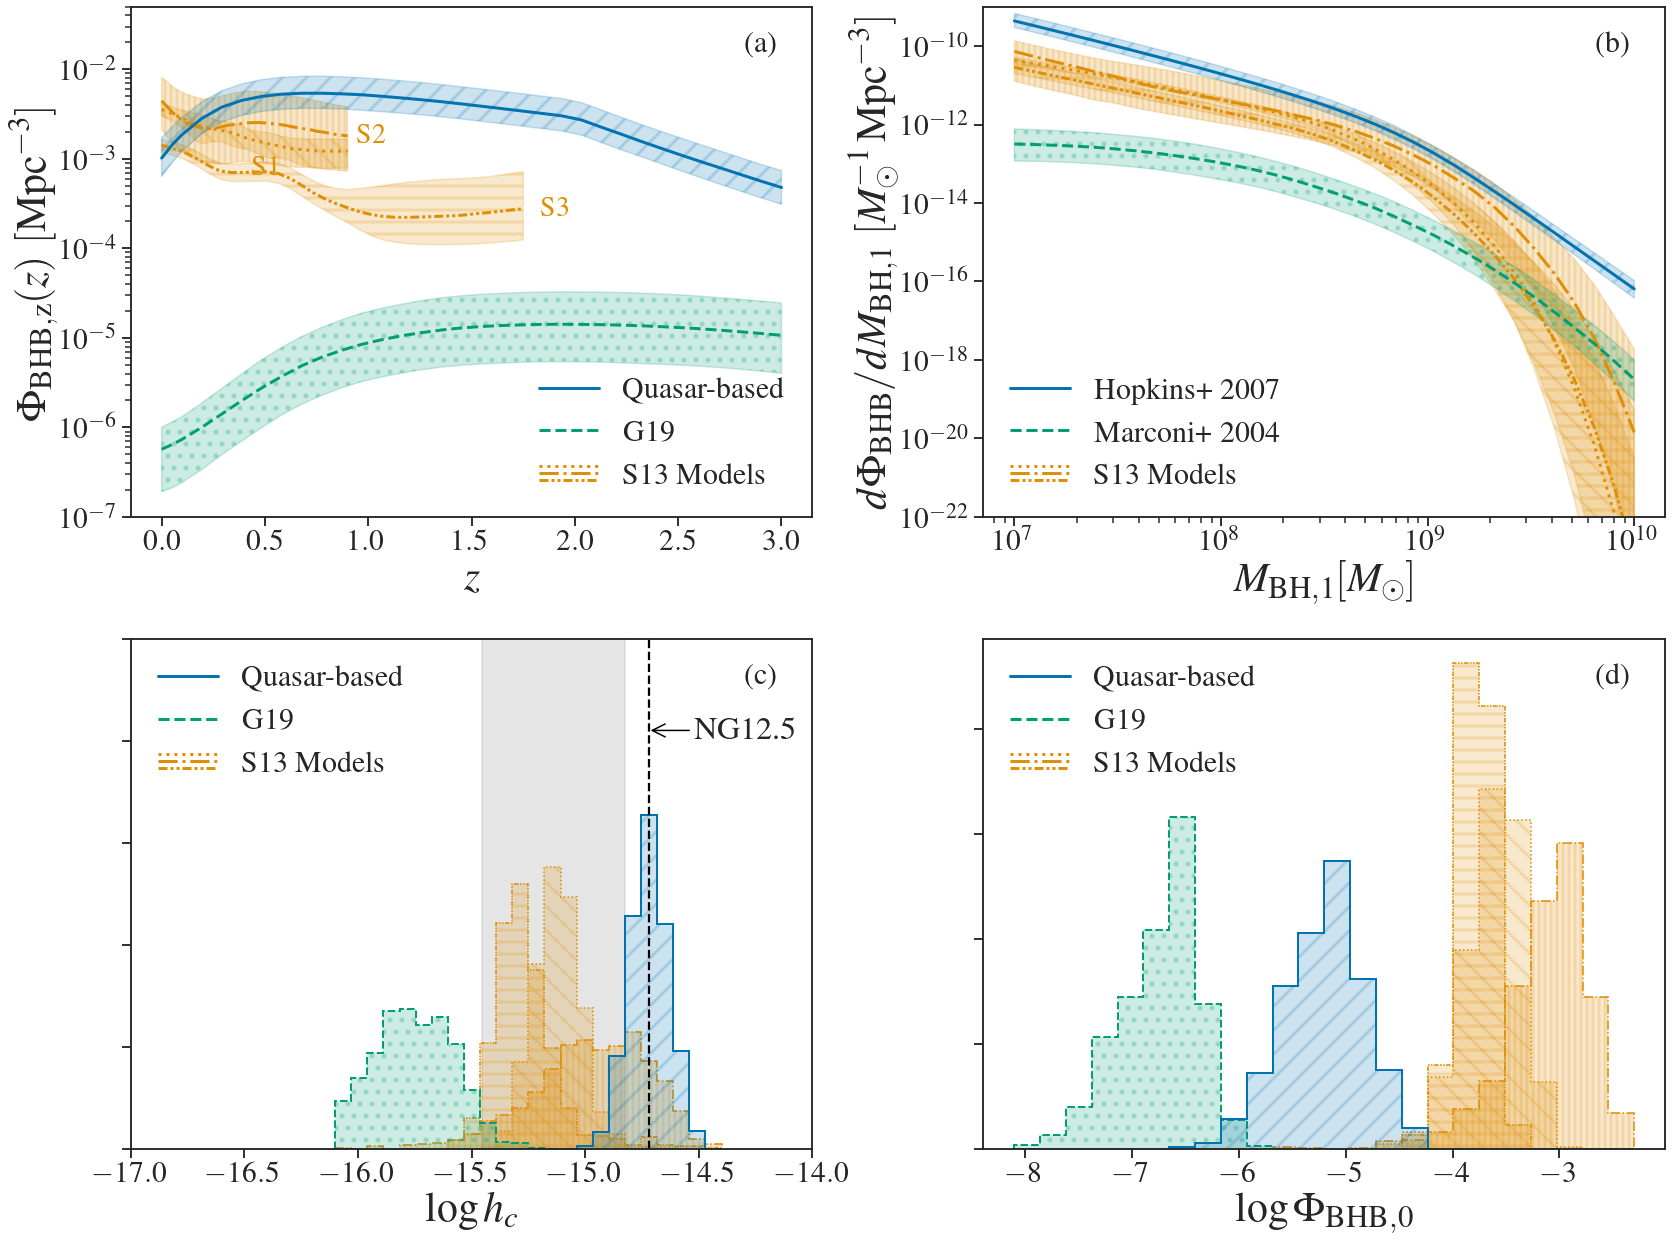

In [205]:
log_nz_i_l_kw_fid_min = np.floor(np.min(np.log10([np.min(differential_number_density_q[1]), np.min(S1_number_density_q[1]),
                                                  np.min(S2_number_density_q[1]), np.min(S3_number_density_q[1])])))
log_nz_i_l_kw_fid_max = np.ceil(np.max(np.log10([np.max(differential_number_density_q[1]), np.max(S1_number_density_q[1]),
                                                 np.max(S2_number_density_q[1]), np.max(S3_number_density_q[1])])))


log_hc_min = np.floor(10 * np.min(np.log10(np.concatenate((hc[-1, -1, -1, :], S1_hc[-1, -1, -1, :],
                                            S2_hc[-1, -1, -1, :], S3_hc[-1, -1, -1, :]))))) / 10
log_hc_max = np.ceil(10 * np.max(np.log10(np.concatenate((hc[-1, -1, -1, :], S1_hc[-1, -1, -1, :],
                                           S2_hc[-1, -1, -1, :], S3_hc[-1, -1, -1, :]))))) / 10

log_n_dens_min = np.floor(10 * np.min(np.log10(np.concatenate((detectable_number_density[0], S1_detectable_number_density[0],
                                            S2_detectable_number_density[0], S3_detectable_number_density[0],
                                                               G19_detectable_number_density[0]))))) / 10
log_n_dens_max = np.ceil(10 * np.max(np.log10(np.concatenate((detectable_number_density[0], S1_detectable_number_density[0],
                                           S2_detectable_number_density[0], S3_detectable_number_density[0],
                                                             G19_detectable_number_density[0]))))) / 10

bins = np.linspace(log_hc_min, log_hc_max, 25)
n_dens_bins = np.linspace(log_n_dens_min, log_n_dens_max, 25)

sesana_min = 3.5e-16
sesana_max = 1.5e-15
log_sesana_min = np.log10(sesana_min)
log_sesana_max = np.log10(sesana_max)
log_sesana_mid = np.mean([log_sesana_min, log_sesana_max])
log_sesana_h = log_sesana_max - log_sesana_mid
log_sesana_l = log_sesana_mid - log_sesana_min

log_hc_mid = np.log10(hc_q[1, -1, -1, -1])
log_hc_min = np.log10(hc_q[0, -1, -1, -1])
log_hc_max = np.log10(hc_q[2, -1, -1, -1])
log_hc_h = log_hc_max - log_hc_mid
log_hc_l = log_hc_mid - log_hc_min

sns.set_context("talk", font_scale=1.8)
fig, ax = plt.subplots(2, 2, figsize=(24, 18))

label_fsize = 42
legend_fsize = 30
text_fs = 28

ax[0, 0].tick_params()
ax[0, 1].tick_params()

ax[0, 0].fill_between(z_range_borch, S1_number_density_q[0], S1_number_density_q[2],
                 color=cs[1], alpha=.2, hatch='\\')
s1, = ax[0, 0].plot(z_range_borch, S1_number_density_q[1], color=cs[1],
                linewidth=3, linestyle=':')
ax[0, 0].text(z_range_borch[int(n_mesh / 2) - 1], .9 * S1_number_density_q[0, int(n_mesh / 2) - 1], 'S1', color=cs[1],
           verticalalignment='top', horizontalalignment='left', fontsize=text_fs)

ax[0, 0].fill_between(z_range_drory, S2_number_density_q[0], S2_number_density_q[2],
                 color=cs[1], alpha=.2, hatch='||')
s2, = ax[0, 0].plot(z_range_drory, S2_number_density_q[1], color=cs[1],
                linewidth=3, linestyle='-.')
ax[0, 0].text(1.05 * z_range_drory[n_mesh - 1], S2_number_density_q[1, n_mesh - 1], 'S2', color=cs[1],
           verticalalignment='center', horizontalalignment='left', fontsize=text_fs)

ax[0, 0].fill_between(z_range_ilbert, S3_number_density_q[0], S3_number_density_q[2],
                 color=cs[1], alpha=.2, hatch='-')
s3, = ax[0, 0].plot(z_range_ilbert, S3_number_density_q[1], color=cs[1],
                linewidth=3, linestyle=(0, (3, 1, 1, 1, 1, 1)))
ax[0, 0].text(1.05 * z_range_ilbert[n_mesh - 1], S3_number_density_q[1, n_mesh - 1], 'S3', color=cs[1],
           verticalalignment='center', horizontalalignment='left', fontsize=text_fs)

ax[0, 0].fill_between(z_range, G19_number_density_q[0], G19_number_density_q[2], color=cs[2], alpha=.2, hatch='.')
m2, = ax[0, 0].plot(z_range, G19_number_density_q[1], color=cs[2], linewidth=3, linestyle='--')

ax[0, 0].fill_between(z_range, differential_number_density_q[0], differential_number_density_q[2], color=cs[0], alpha=.2, hatch='/')
m1, = ax[0, 0].plot(z_range, differential_number_density_q[1], color=cs[0], linewidth=3, linestyle='-')

ax[0, 0].set_yscale('log')
ax[0, 0].set_ylabel(r'$\Phi_{\rm{BHB}, z}(z)\ [\rm{Mpc}^{-3}]$', fontsize=label_fsize)
ax[0, 0].set_xlabel(r'$z$', fontsize=label_fsize)
# ax[0].set_ylim((10 ** (log_nz_i_l_kw_fid_min - 1), 10 ** (log_nz_i_l_kw_fid_max + 1)))
ax[0, 0].set_ylim(top=5e-2, bottom=1e-7)

ax[0, 0].legend([m1, m2, (s1, s2, s3)], ['Quasar-based', 'G19', 'S13 Models'], numpoints=1,
             handler_map={tuple: HandlerTupleVertical(ndivide=None)}, loc='lower right', frameon=False, fontsize=legend_fsize)

ax[0, 0].text(.95, .95, '(a)', fontsize=legend_fsize, verticalalignment='top', horizontalalignment='right', transform=ax[0, 0].transAxes)

ax[0, 1].fill_between(10 ** log_m_bh_range, S1_total_bhmf_q[0], S1_total_bhmf_q[2], color=cs[1], alpha=.2, hatch='\\')
s1, = ax[0, 1].plot(10 ** log_m_bh_range, S1_total_bhmf_q[1], color=cs[1],
                 linewidth=3, linestyle=':')
ax[0, 1].fill_between(10 ** log_m_bh_range, S2_total_bhmf_q[0], S2_total_bhmf_q[2], color=cs[1], alpha=.2, hatch='||')
s2, = ax[0, 1].plot(10 ** log_m_bh_range, S2_total_bhmf_q[1], color=cs[1],
                 linewidth=3, linestyle='-.')
ax[0, 1].fill_between(10 ** log_m_bh_range, S3_total_bhmf_q[0], S3_total_bhmf_q[2], color=cs[1], alpha=.2, hatch='-')
s3, = ax[0, 1].plot(10 ** log_m_bh_range, S3_total_bhmf_q[1], color=cs[1],
                 linewidth=3, linestyle=(0, (3, 1, 1, 1, 1, 1)))

ax[0, 1].fill_between(10 ** log_m_bh_range, G19_total_bhmf_q[0][log_m_chirp_range != log_m_chirp_norm_min],
                   G19_total_bhmf_q[2][log_m_chirp_range != log_m_chirp_norm_min], color=cs[2], alpha=.2, hatch='.')
m2, = ax[0, 1].plot(10 ** log_m_bh_range, G19_total_bhmf_q[1][log_m_chirp_range != log_m_chirp_norm_min], color=cs[2], linewidth=3, linestyle='--')

ax[0, 1].fill_between(10 ** log_m_bh_range, total_bhmf_q[0], total_bhmf_q[2], color=cs[0], alpha=.2, hatch='/')
m1, = ax[0, 1].plot(10 ** log_m_bh_range, total_bhmf_q[1], color=cs[0], linewidth=3, linestyle='-')

ax[0, 1].set_xscale('log')
ax[0, 1].set_yscale('log')
ax[0, 1].set_ylabel(r'$d \Phi_{\rm{BHB}} / d M_{\rm{BH}, 1}\ [M_{\odot}^{-1}\,\rm{Mpc}^{-3}]$', fontsize=label_fsize)
ax[0, 1].set_xlabel(r'$M_{\rm{BH}, 1} [M_{\odot}]$', fontsize=label_fsize)
ax[0, 1].set_ylim(bottom=1e-22, top=1e-9)
ax[0, 1].legend([m1, m2, (s1, s2, s3)], ['Hopkins+ 2007', 'Marconi+ 2004', 'S13 Models'], numpoints=1,
             handler_map={tuple: HandlerTupleVertical(ndivide=None)}, loc='lower left', frameon=False, fontsize=legend_fsize)
ax[0, 1].text(.95, .95, '(b)', fontsize=legend_fsize, verticalalignment='top', horizontalalignment='right', transform=ax[0, 1].transAxes)

ax[1, 0].axvspan(log_sesana_min, log_sesana_max, color='k', alpha=.1)
ax[1, 0].hist(np.log10(S1_hc[-1, -1, -1, :]), histtype='step', bins=bins,
           density=False, color=cs[1], linestyle=':',
           label=r'S13: Realization 1',
           weights=np.repeat(1 / len(S1_hc[-1, -1, -1, :]), len(S1_hc[-1, -1, -1, :])),
           fill=True, alpha=.2, hatch='\\')
ax[1, 0].hist(np.log10(S1_hc[-1, -1, -1, :]), histtype='step', bins=bins,
           density=False, color=cs[1], linestyle=':',
           label=r'S13: Realization 1',
           weights=np.repeat(1 / len(S1_hc[-1, -1, -1, :]), len(S1_hc[-1, -1, -1, :])))

ax[1, 0].hist(np.log10(S2_hc[-1, -1, -1, :]), histtype='step', bins=bins,
           density=False, color=cs[1], linestyle='-.',
           label=r'S13: Realization 2',
           weights=np.repeat(1 / len(S2_hc[-1, -1, -1, :]), len(S2_hc[-1, -1, -1, :])),
           fill=True, alpha=.2, hatch='||')
ax[1, 0].hist(np.log10(S2_hc[-1, -1, -1, :]), histtype='step', bins=bins,
           density=False, color=cs[1], linestyle='-.',
           label=r'S13: Realization 2',
           weights=np.repeat(1 / len(S2_hc[-1, -1, -1, :]), len(S2_hc[-1, -1, -1, :])))

ax[1, 0].hist(np.log10(S3_hc[-1, -1, -1, :]), histtype='step', bins=bins,
           density=False, color=cs[1], linestyle=(0, (3, 1, 1, 1, 1, 1)),
           label=r'S13: Realization 3',
           weights=np.repeat(1 / len(S3_hc[-1, -1, -1, :]), len(S3_hc[-1, -1, -1, :])),
           fill=True, alpha=.2, hatch='-')
ax[1, 0].hist(np.log10(S3_hc[-1, -1, -1, :]), histtype='step', bins=bins,
           density=False, color=cs[1], linestyle=(0, (3, 1, 1, 1, 1, 1)),
           label=r'S13: Realization 3',
           weights=np.repeat(1 / len(S3_hc[-1, -1, -1, :]), len(S3_hc[-1, -1, -1, :])))

ax[1, 0].hist(np.log10(G19_hc[-1, -1, :]), histtype='step', bins=bins, density=False, color=cs[2], linestyle='--',
           label=r'G19', weights=np.repeat(1 / len(G19_hc[-1, -1, :]), len(G19_hc[-1, -1, :])), linewidth=2, fill=True, alpha=.2, hatch='.')
ax[1, 0].hist(np.log10(G19_hc[-1, -1, :]), histtype='step', bins=bins, density=False, color=cs[2], linestyle='--',
           label=r'G19', weights=np.repeat(1 / len(G19_hc[-1, -1, :]), len(G19_hc[-1, -1, :])), linewidth=2)

ax[1, 0].hist(np.log10(hc[-1, -1, -1, :]), histtype='step', bins=bins, density=False, color=cs[0], linestyle='-',
           label=r'Quasar-based', weights=np.repeat(1 / len(hc[-1, -1, -1, :]), len(hc[-1, -1, -1, :])), linewidth=2,
           fill=True, alpha=.2, hatch='/')
ax[1, 0].hist(np.log10(hc[-1, -1, -1, :]), histtype='step', bins=bins, density=False, color=cs[0], linestyle='-',
           label=r'Quasar-based', weights=np.repeat(1 / len(hc[-1, -1, -1, :]), len(hc[-1, -1, -1, :])), linewidth=2)

ax[1, 0].axvline(np.log10(1.9e-15), color='k', linestyle='--')
ax[1, 0].annotate(r'NG12.5',
               xy=(np.log10(1.9e-15), .41), xytext=(np.log10(1.9e-15) + 0.2, .41), xycoords='data', textcoords='data',
               arrowprops=dict(arrowstyle="->", linestyle='-', color='k',
                              relpos=(0,.5)), ha='left', va='center')
ax[1, 0].set_xlabel(r'$\log h_{c}$', fontsize=label_fsize)
ax[1, 0].set_yticklabels([])
# ax[1, 0].set_ylabel(r'$P(h_{c})$', fontsize=label_fsize)
ax[1, 0].set_xlim(left=-17, right=-14)
ax[1, 0].set_ylim(top=.5)
ax[1, 0].legend([m1, m2, (s1, s2, s3)], ['Quasar-based', 'G19', 'S13 Models'], numpoints=1,
             handler_map={tuple: HandlerTupleVertical(ndivide=None)}, frameon=False, loc='upper left', fontsize=legend_fsize)
ax[1, 0].text(.95, .95, '(c)', fontsize=legend_fsize, verticalalignment='top', horizontalalignment='right', transform=ax[1, 0].transAxes)

# ax[1, 1].axvspan(log_sesana_min, log_sesana_max, color='k', alpha=.1)
ax[1, 1].hist(np.log10(S1_detectable_number_density[0]), histtype='step', bins=n_dens_bins,
           density=False, color=cs[1], linestyle=':',
           label=r'S13: Realization 1',
           weights=np.repeat(1 / len(S1_detectable_number_density[0]), len(S1_detectable_number_density[0])),
           fill=True, alpha=.2, hatch='\\')
ax[1, 1].hist(np.log10(S1_detectable_number_density[0]), histtype='step', bins=n_dens_bins,
           density=False, color=cs[1], linestyle=':',
           label=r'S13: Realization 1',
           weights=np.repeat(1 / len(S1_detectable_number_density[0]), len(S1_detectable_number_density[0])))

ax[1, 1].hist(np.log10(S2_detectable_number_density[0]), histtype='step', bins=n_dens_bins,
           density=False, color=cs[1], linestyle='-.',
           label=r'S13: Realization 2',
           weights=np.repeat(1 / len(S2_detectable_number_density[0]), len(S2_detectable_number_density[0])),
           fill=True, alpha=.2, hatch='||')
ax[1, 1].hist(np.log10(S2_detectable_number_density[0]), histtype='step', bins=n_dens_bins,
           density=False, color=cs[1], linestyle='-.',
           label=r'S13: Realization 2',
           weights=np.repeat(1 / len(S2_detectable_number_density[0]), len(S2_detectable_number_density[0])))

ax[1, 1].hist(np.log10(S3_detectable_number_density[0]), histtype='step', bins=n_dens_bins,
           density=False, color=cs[1], linestyle=(0, (3, 1, 1, 1, 1, 1)),
           label=r'S13: Realization 3',
           weights=np.repeat(1 / len(S3_detectable_number_density[0]), len(S3_detectable_number_density[0])),
           fill=True, alpha=.2, hatch='-')
ax[1, 1].hist(np.log10(S3_detectable_number_density[0]), histtype='step', bins=n_dens_bins,
           density=False, color=cs[1], linestyle=(0, (3, 1, 1, 1, 1, 1)),
           label=r'S13: Realization 3',
           weights=np.repeat(1 / len(S3_detectable_number_density[0]), len(S3_detectable_number_density[0])))

ax[1, 1].hist(np.log10(G19_detectable_number_density[0]), histtype='step', bins=n_dens_bins, density=False, color=cs[2], linestyle='--',
           label=r'G19', weights=np.repeat(1 / len(G19_detectable_number_density[0]), len(G19_detectable_number_density[0])),
              linewidth=2, fill=True, alpha=.2, hatch='.')
ax[1, 1].hist(np.log10(G19_detectable_number_density[0]), histtype='step', bins=n_dens_bins, density=False, color=cs[2], linestyle='--',
           label=r'G19', weights=np.repeat(1 / len(G19_detectable_number_density[0]), len(G19_detectable_number_density[0])), linewidth=2)

ax[1, 1].hist(np.log10(detectable_number_density[0]), histtype='step', bins=n_dens_bins, density=False, color=cs[0], linestyle='-',
           label=r'Quasar-based', weights=np.repeat(1 / len(detectable_number_density[0]), len(detectable_number_density[0])), linewidth=2,
           fill=True, alpha=.2, hatch='/')
ax[1, 1].hist(np.log10(detectable_number_density[0]), histtype='step', bins=n_dens_bins, density=False, color=cs[0], linestyle='-',
           label=r'Quasar-based', weights=np.repeat(1 / len(detectable_number_density[0]), len(detectable_number_density[0])), linewidth=2)

# ax[1, 1].axvline(np.log10(1.9e-15), color='k', linestyle='--')
# ax[1, 1].annotate(r'NG12.5',
#                xy=(np.log10(1.9e-15), .41), xytext=(np.log10(1.9e-15) + 0.2, .41), xycoords='data', textcoords='data',
#                arrowprops=dict(arrowstyle="->", linestyle='-', color='k',
#                               relpos=(0,.5)), ha='left', va='center')
ax[1, 1].set_xlabel(r'$\log \Phi_{\rm{BHB}, 0}$', fontsize=label_fsize)
ax[1, 1].set_yticklabels([])
# ax[1, 1].set_xlim(left=-17, right=-14)
# ax[1, 1].set_ylim(top=.5)
ax[1, 1].legend([m1, m2, (s1, s2, s3)], ['Quasar-based', 'G19', 'S13 Models'], numpoints=1,
             handler_map={tuple: HandlerTupleVertical(ndivide=None)}, frameon=False, loc='upper left', fontsize=legend_fsize)
ax[1, 1].text(.95, .95, '(d)', fontsize=legend_fsize, verticalalignment='top', horizontalalignment='right', transform=ax[1, 1].transAxes)

plt.tight_layout()
plt.savefig('../reports/figures/model_comparison.pdf')
plt.savefig('../reports/figures/model_comparison.png')
plt.show()

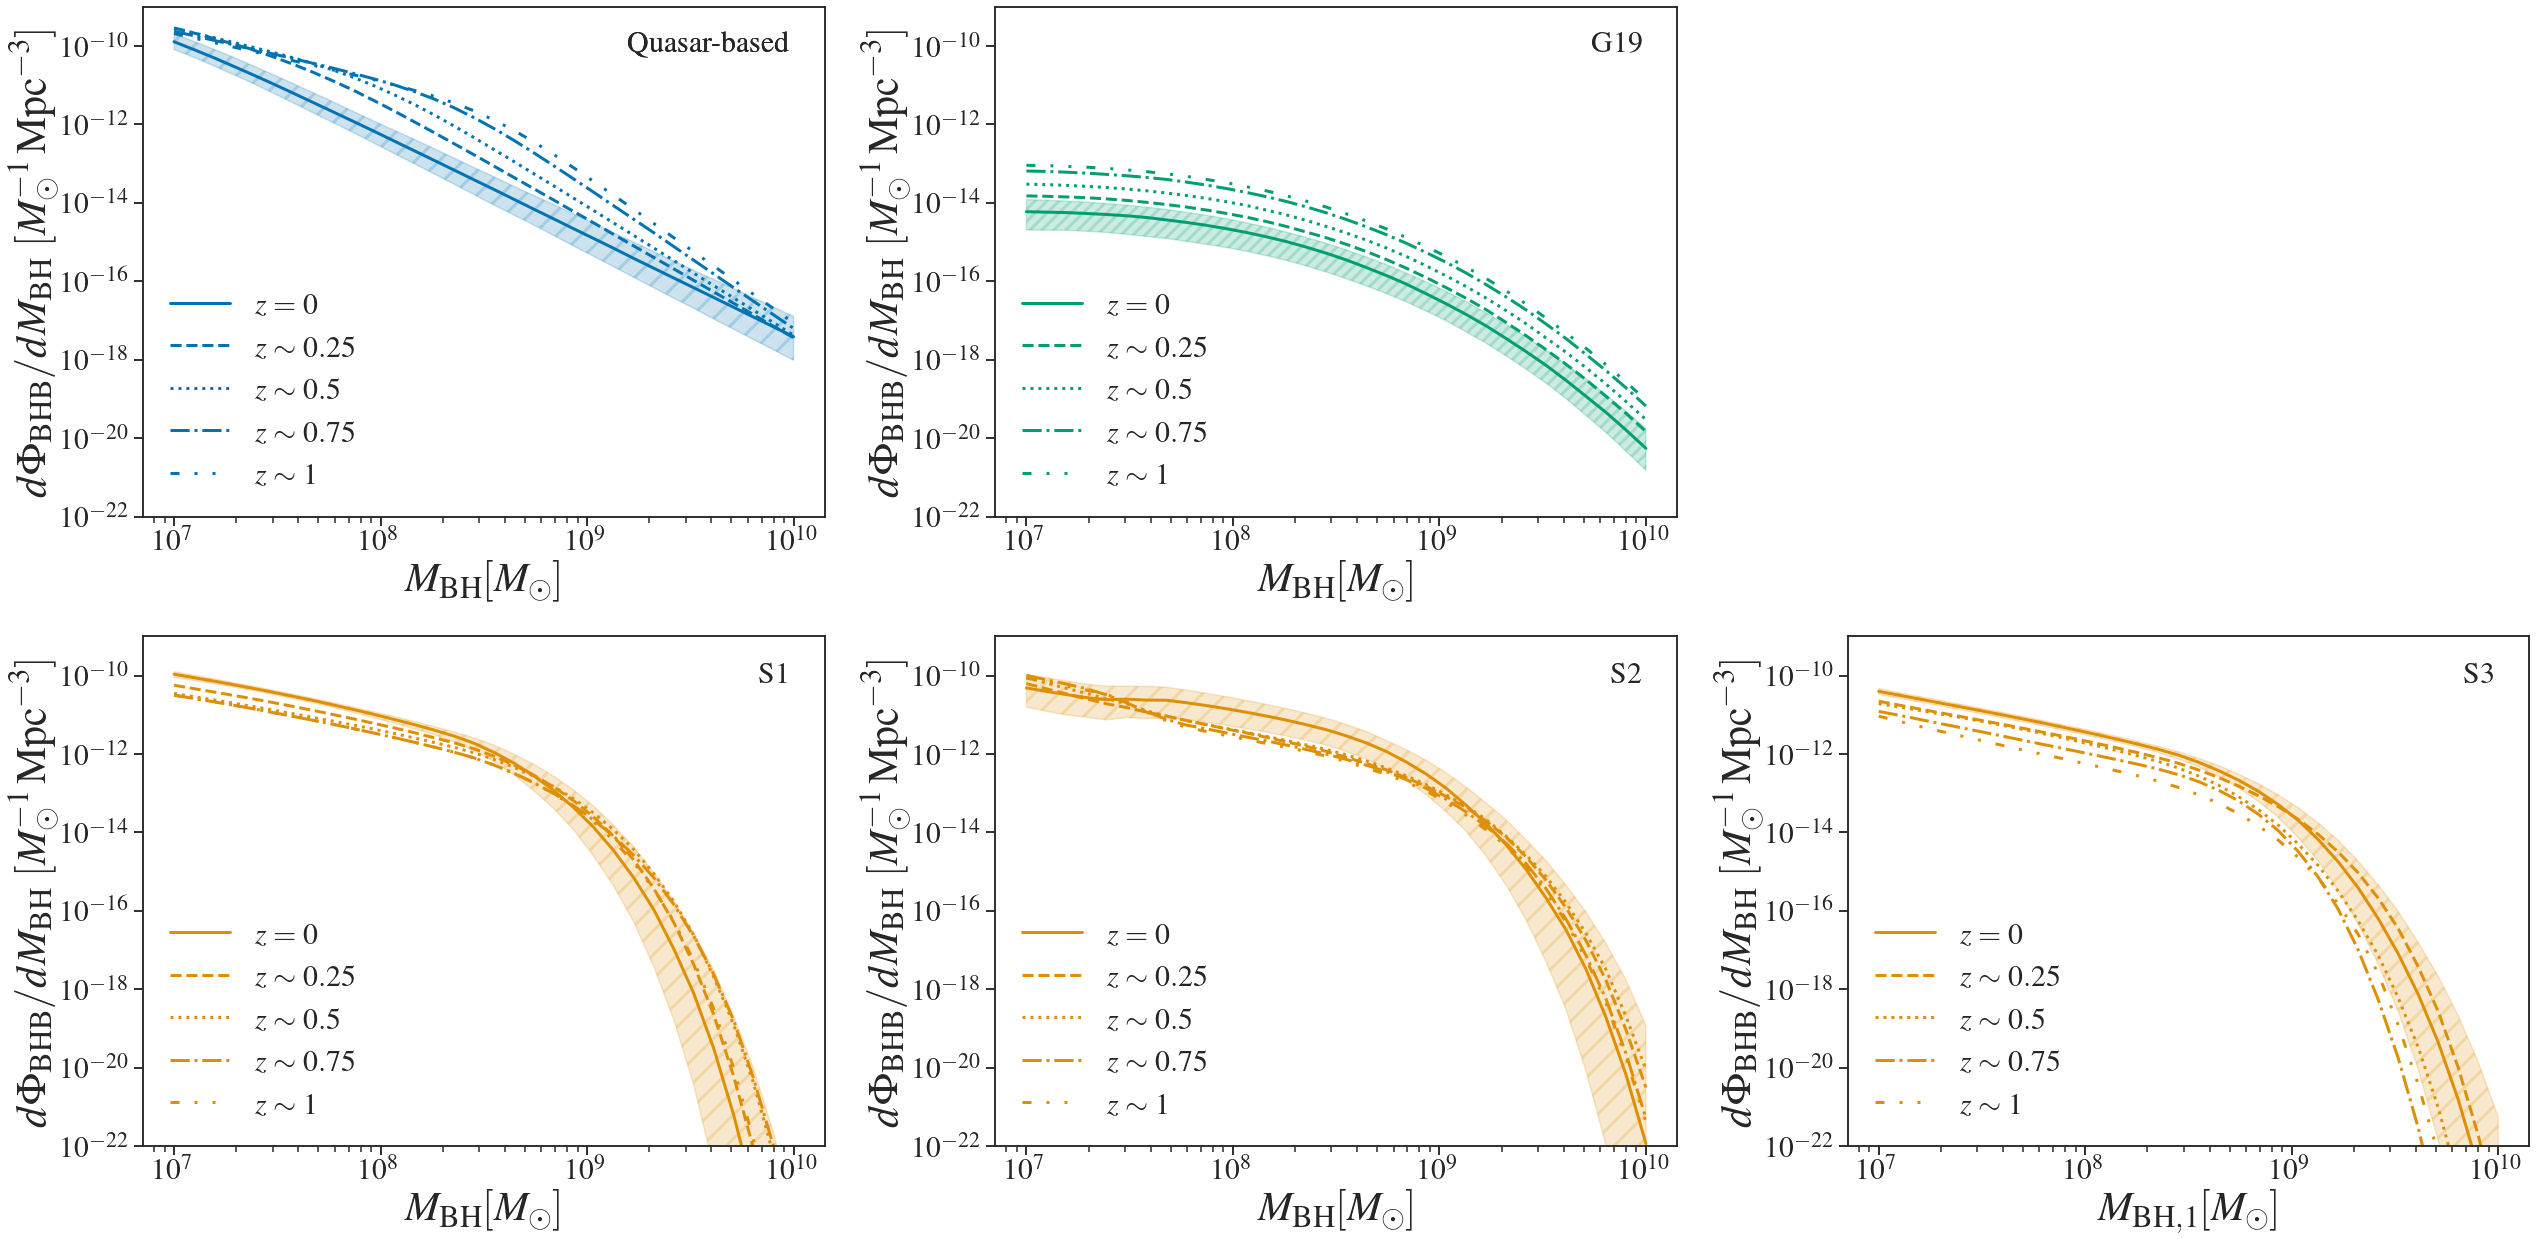

In [206]:
sns.set_context("talk", font_scale=1.8)
fig, ax = plt.subplots(2, 3, figsize=(36, 18))

label_fsize = 42
legend_fsize = 30
text_fs = 28

ax[0, 0].tick_params()
ax[0, 1].tick_params()


ax[0, 0].fill_between(10 ** log_m_bh_range, bhmf_q[0, :, 0], bhmf_q[2, :, 0], color=cs[0], alpha=.2, hatch='/')
ax[0, 0].plot(10 ** log_m_bh_range, bhmf_q[1, :, 0], color=cs[0], linewidth=3, linestyle='-', label=r'$z = 0$')
ax[0, 0].plot(10 ** log_m_bh_range, np.squeeze(bhmf_q[1, :, np.abs(.25 - z_range) == np.min(np.abs(.25 - z_range))]),
           color=cs[0], linewidth=3, linestyle='--', label=r'$z \sim 0.25$')
ax[0, 0].plot(10 ** log_m_bh_range, np.squeeze(bhmf_q[1, :, np.abs(.5 - z_range) == np.min(np.abs(.5 - z_range))]),
           color=cs[0], linewidth=3, linestyle=':', label=r'$z \sim 0.5$')
ax[0, 0].plot(10 ** log_m_bh_range, np.squeeze(bhmf_q[1, :, np.abs(.75 - z_range) == np.min(np.abs(.75 - z_range))]),
           color=cs[0], linewidth=3, linestyle='-.', label=r'$z \sim 0.75$')
ax[0, 0].plot(10 ** log_m_bh_range, np.squeeze(bhmf_q[1, :, np.abs(1 - z_range) == np.min(np.abs(1 - z_range))]),
           color=cs[0], linewidth=3, linestyle=(0, (3, 5, 1, 5, 1, 5)), label=r'$z \sim 1$')
ax[0, 0].text(.95, .95, 'Quasar-based', fontsize=legend_fsize, verticalalignment='top',
              horizontalalignment='right', transform=ax[0, 0].transAxes)

ax[0, 0].text(.95, .95, 'Quasar-based', fontsize=legend_fsize, verticalalignment='top',
              horizontalalignment='right', transform=ax[0, 0].transAxes)
ax[0, 0].set_xscale('log')
ax[0, 0].set_yscale('log')
ax[0, 0].set_ylabel(r'$d \Phi_{\rm{BHB}} / d M_{\rm{BH}}\ [M_{\odot}^{-1}\,\rm{Mpc}^{-3}]$', fontsize=label_fsize)
ax[0, 0].set_xlabel(r'$M_{\rm{BH}} [M_{\odot}]$', fontsize=label_fsize)
ax[0, 0].set_ylim(bottom=1e-22, top=1e-9)
ax[0, 0].legend(frameon=False, fontsize=legend_fsize, loc='lower left')

ax[0, 1].fill_between(10 ** log_m_bh_range, G19_bhmf_q[0, log_m_chirp_range != log_m_chirp_norm_min, 0],
                      G19_bhmf_q[2, log_m_chirp_range != log_m_chirp_norm_min, 0], color=cs[2], alpha=.2, hatch='//')
ax[0, 1].plot(10 ** log_m_bh_range, G19_bhmf_q[1, log_m_chirp_range != log_m_chirp_norm_min, 0], color=cs[2], linewidth=3, linestyle='-', label=r'$z = 0$')
ax[0, 1].plot(10 ** log_m_bh_range, np.squeeze(G19_bhmf_q[1, log_m_chirp_range != log_m_chirp_norm_min, np.abs(.25 - z_range) == np.min(np.abs(.25 - z_range))]),
           color=cs[2], linewidth=3, linestyle='--', label=r'$z \sim 0.25$')
ax[0, 1].plot(10 ** log_m_bh_range, np.squeeze(G19_bhmf_q[1, log_m_chirp_range != log_m_chirp_norm_min, np.abs(.5 - z_range) == np.min(np.abs(.5 - z_range))]),
           color=cs[2], linewidth=3, linestyle=':', label=r'$z \sim 0.5$')
ax[0, 1].plot(10 ** log_m_bh_range, np.squeeze(G19_bhmf_q[1, log_m_chirp_range != log_m_chirp_norm_min, np.abs(.75 - z_range) == np.min(np.abs(.75 - z_range))]),
           color=cs[2], linewidth=3, linestyle='-.', label=r'$z \sim 0.75$')
ax[0, 1].plot(10 ** log_m_bh_range, np.squeeze(G19_bhmf_q[1, log_m_chirp_range != log_m_chirp_norm_min, np.abs(1 - z_range) == np.min(np.abs(1 - z_range))]),
           color=cs[2], linewidth=3, linestyle=(0, (3, 5, 1, 5, 1, 5)), label=r'$z \sim 1$')

ax[0, 1].text(.95, .95, 'G19', fontsize=legend_fsize, verticalalignment='top',
              horizontalalignment='right', transform=ax[0, 1].transAxes)
ax[0, 1].set_xscale('log')
ax[0, 1].set_yscale('log')
ax[0, 1].set_ylabel(r'$d \Phi_{\rm{BHB}} / d M_{\rm{BH}}\ [M_{\odot}^{-1}\,\rm{Mpc}^{-3}]$', fontsize=label_fsize)
ax[0, 1].set_xlabel(r'$M_{\rm{BH}} [M_{\odot}]$', fontsize=label_fsize)
ax[0, 1].set_ylim(bottom=1e-22, top=1e-9)
ax[0, 1].legend(frameon=False, fontsize=legend_fsize, loc='lower left')

ax[0, 2].set_axis_off()

ax[1, 0].fill_between(10 ** log_m_bh_range, S1_bhmf_q[0, :, 0], S1_bhmf_q[2, :, 0], color=cs[1], alpha=.2, hatch='/')
ax[1, 0].plot(10 ** log_m_bh_range, S1_bhmf_q[1, :, 0], color=cs[1], linewidth=3, linestyle='-', label=r'$z = 0$')
ax[1, 0].plot(10 ** log_m_bh_range, S1_bhmf_q[1, :, np.abs(.25 - z_range_borch) == np.min(np.abs(.25 - z_range_borch))][0],
           color=cs[1], linewidth=3, linestyle='--', label=r'$z \sim 0.25$')
ax[1, 0].plot(10 ** log_m_bh_range, S1_bhmf_q[1, :, np.abs(.5 - z_range_borch) == np.min(np.abs(.5 - z_range_borch))][0],
           color=cs[1], linewidth=3, linestyle=':', label=r'$z \sim 0.5$')
ax[1, 0].plot(10 ** log_m_bh_range, S1_bhmf_q[1, :, np.abs(.75 - z_range_borch) == np.min(np.abs(.75 - z_range_borch))][0],
           color=cs[1], linewidth=3, linestyle='-.', label=r'$z \sim 0.75$')
ax[1, 0].plot(10 ** log_m_bh_range, S1_bhmf_q[1, :, np.abs(1 - z_range_borch) == np.min(np.abs(1 - z_range_borch))][0],
           color=cs[1], linewidth=3, linestyle=(0, (3, 5, 1, 5, 1, 5)), label=r'$z \sim 1$')
ax[1, 0].text(.95, .95, 'S1', fontsize=legend_fsize, verticalalignment='top',
              horizontalalignment='right', transform=ax[1, 0].transAxes)

ax[1, 0].set_xscale('log')
ax[1, 0].set_yscale('log')
ax[1, 0].set_ylabel(r'$d \Phi_{\rm{BHB}} / d M_{\rm{BH}}\ [M_{\odot}^{-1}\,\rm{Mpc}^{-3}]$', fontsize=label_fsize)
ax[1, 0].set_xlabel(r'$M_{\rm{BH}} [M_{\odot}]$', fontsize=label_fsize)
ax[1, 0].set_ylim(bottom=1e-22, top=1e-9)
ax[1, 0].legend(frameon=False, fontsize=legend_fsize, loc='lower left')

ax[1, 1].fill_between(10 ** log_m_bh_range, S2_bhmf_q[0, :, 0], S2_bhmf_q[2, :, 0], color=cs[1], alpha=.2, hatch='/')
ax[1, 1].plot(10 ** log_m_bh_range, S2_bhmf_q[1, :, 0], color=cs[1], linewidth=3, linestyle='-', label=r'$z = 0$')
ax[1, 1].plot(10 ** log_m_bh_range, S2_bhmf_q[1, :, np.abs(.25 - z_range_drory) == np.min(np.abs(.25 - z_range_drory))][0],
           color=cs[1], linewidth=3, linestyle='--', label=r'$z \sim 0.25$')
ax[1, 1].plot(10 ** log_m_bh_range, S2_bhmf_q[1, :, np.abs(.5 - z_range_drory) == np.min(np.abs(.5 - z_range_drory))][0],
           color=cs[1], linewidth=3, linestyle=':', label=r'$z \sim 0.5$')
ax[1, 1].plot(10 ** log_m_bh_range, S2_bhmf_q[1, :, np.abs(.75 - z_range_drory) == np.min(np.abs(.75 - z_range_drory))][0],
           color=cs[1], linewidth=3, linestyle='-.', label=r'$z \sim 0.75$')
ax[1, 1].plot(10 ** log_m_bh_range, S2_bhmf_q[1, :, np.abs(1 - z_range_drory) == np.min(np.abs(1 - z_range_drory))][0],
           color=cs[1], linewidth=3, linestyle=(0, (3, 5, 1, 5, 1, 5)), label=r'$z \sim 1$')
ax[1, 1].text(.95, .95, 'S2', fontsize=legend_fsize, verticalalignment='top',
              horizontalalignment='right', transform=ax[1, 1].transAxes)

ax[1, 1].set_xscale('log')
ax[1, 1].set_yscale('log')
ax[1, 1].set_ylabel(r'$d \Phi_{\rm{BHB}} / d M_{\rm{BH}}\ [M_{\odot}^{-1}\,\rm{Mpc}^{-3}]$', fontsize=label_fsize)
ax[1, 1].set_xlabel(r'$M_{\rm{BH}} [M_{\odot}]$', fontsize=label_fsize)
ax[1, 1].set_ylim(bottom=1e-22, top=1e-9)
ax[1, 1].legend(frameon=False, fontsize=legend_fsize, loc='lower left')

ax[1, 2].fill_between(10 ** log_m_bh_range, S3_bhmf_q[0, :, 0], S3_bhmf_q[2, :, 0], color=cs[1], alpha=.2, hatch='/')
ax[1, 2].plot(10 ** log_m_bh_range, S3_bhmf_q[1, :, 0], color=cs[1], linewidth=3, linestyle='-', label=r'$z = 0$')
ax[1, 2].plot(10 ** log_m_bh_range, S3_bhmf_q[1, :, np.abs(.25 - z_range_ilbert) == np.min(np.abs(.25 - z_range_ilbert))][0],
               color=cs[1], linewidth=3, linestyle='--', label=r'$z \sim 0.25$')
ax[1, 2].plot(10 ** log_m_bh_range, S3_bhmf_q[1, :, np.abs(.5 - z_range_ilbert) == np.min(np.abs(.5 - z_range_ilbert))][0],
               color=cs[1], linewidth=3, linestyle=':', label=r'$z \sim 0.5$')
ax[1, 2].plot(10 ** log_m_bh_range, S3_bhmf_q[1, :, np.abs(.75 - z_range_ilbert) == np.min(np.abs(.75 - z_range_ilbert))][0],
               color=cs[1], linewidth=3, linestyle='-.', label=r'$z \sim 0.75$')
ax[1, 2].plot(10 ** log_m_bh_range, S3_bhmf_q[1, :, np.abs(1 - z_range_ilbert) == np.min(np.abs(1 - z_range_ilbert))][0],
             color=cs[1], linewidth=3, linestyle=(0, (3, 5, 1, 5, 1, 5)), label=r'$z \sim 1$')
ax[1, 2].text(.95, .95, 'S3', fontsize=legend_fsize, verticalalignment='top',
              horizontalalignment='right', transform=ax[1, 2].transAxes)

ax[1, 2].set_xscale('log')
ax[1, 2].set_yscale('log')
ax[1, 2].set_ylabel(r'$d \Phi_{\rm{BHB}} / d M_{\rm{BH}}\ [M_{\odot}^{-1}\,\rm{Mpc}^{-3}]$', fontsize=label_fsize)
ax[1, 2].set_xlabel(r'$M_{\rm{BH}, 1} [M_{\odot}]$', fontsize=label_fsize)
ax[1, 2].set_ylim(bottom=1e-22, top=1e-9)
ax[1, 2].legend(frameon=False, fontsize=legend_fsize, loc='lower left')

plt.tight_layout()
plt.savefig('../reports/figures/bhmf.pdf')
plt.savefig('../reports/figures/bhmf.png')
plt.show()

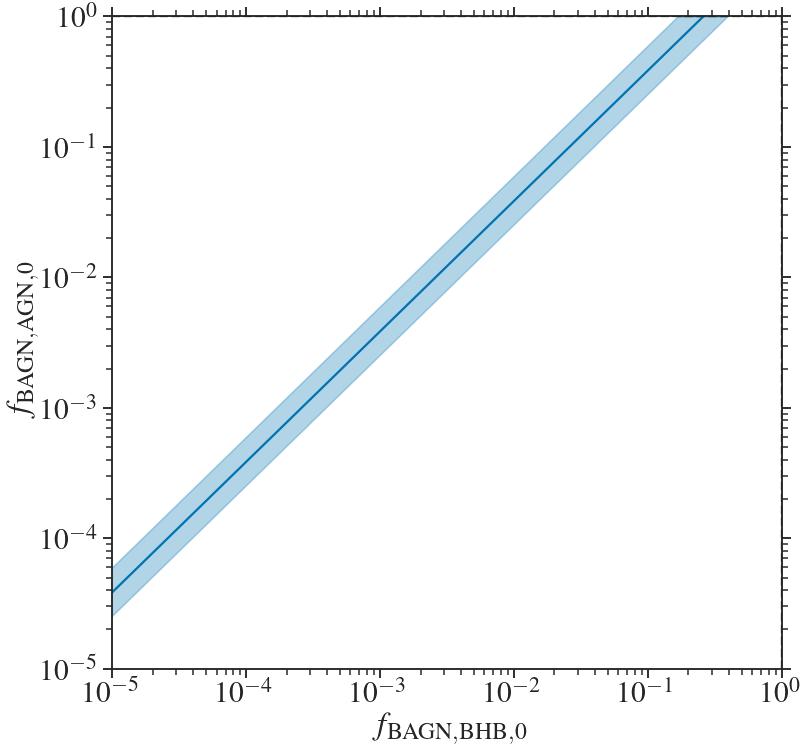

In [207]:
plt.figure(figsize=(12, 12))
# plt.plot(f_bagn_bhb_space, f_bagn_agn_q[1], color=cs[0])
# plt.fill_between(f_bagn_bhb_space, f_bagn_agn_q[0], f_bagn_agn_q[2], color=cs[0], alpha=.3)

f_bagn_bhb_q = np.quantile(f_bagn_bhb, q=[.16, .5, .84], axis=-1)

plt.plot(f_bagn_bhb_q[1], f_bagn_agn_space, color=cs[0])
plt.fill_betweenx(f_bagn_agn_space, f_bagn_bhb_q[0], f_bagn_bhb_q[2], color=cs[0], alpha=.3)
# plt.scatter(np.repeat(f_bagn_bhb_space[:, np.newaxis], n_samples, axis=1), f_bagn_agn)
# plt.scatter(f_bagn_bhb, np.repeat(f_bagn_agn_space[:, np.newaxis], n_samples, axis=1))
plt.axhline(1, color='k', linestyle='--')
plt.axvline(1, color='k', linestyle='--')

plt.xscale('log')
plt.xlim(right=1, left=1e-5)
plt.xlabel(r'$f_{\rm{BAGN, BHB}, 0}$')

plt.yscale('log')
plt.ylim(top=1, bottom=1e-5)
plt.ylabel(r'$f_{\rm{BAGN, AGN}, 0}$')

plt.tick_params(which='both', top=True, right=True)

plt.savefig('../reports/figures/frac_ratio.pdf')
plt.savefig('../reports/figures/frac_ratio.png')
plt.show()

In [208]:
f_space = np.logspace(-7, -9) * u.Hz

# Quasar based model
hc_f = hc[-1, -1, -1, :, np.newaxis] * (f_space[np.newaxis, :] * u.yr).to('') ** (-2 / 3)
hc_f_q = np.quantile(hc_f, q=[.16, .5, .84], axis=0)

# S1
hc_f_S1 = S1_hc[-1, -1, -1, :, np.newaxis] * (f_space[np.newaxis, :] * u.yr).to('') ** (-2 / 3)
hc_f_S1_q = np.quantile(hc_f_S1, q=[.16, .5, .84], axis=0)

# S2
hc_f_S2 = S2_hc[-1, -1, -1, :, np.newaxis] * (f_space[np.newaxis, :] * u.yr).to('') ** (-2 / 3)
hc_f_S2_q = np.quantile(hc_f_S2, q=[.16, .5, .84], axis=0)

# S3
hc_f_S3 = S3_hc[-1, -1, -1, :, np.newaxis] * (f_space[np.newaxis, :] * u.yr).to('') ** (-2 / 3)
hc_f_S3_q = np.quantile(hc_f_S3, q=[.16, .5, .84], axis=0)

# G19
hc_f_G19 = G19_hc[-1, -1, :, np.newaxis] * (f_space[np.newaxis, :] * u.yr).to('') ** (-2 / 3)
hc_f_G19_q = np.quantile(hc_f_G19, q=[.16, .5, .84], axis=0)

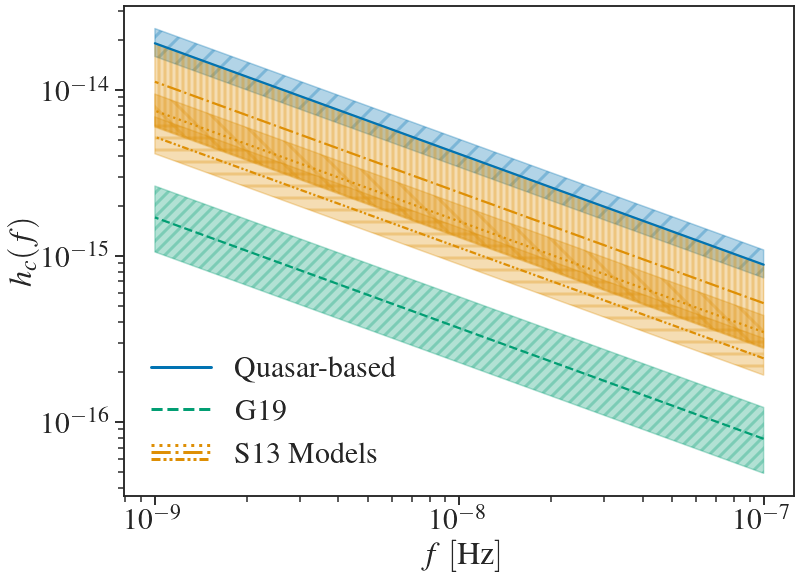

In [209]:
plt.figure(figsize=(12, 9))

# NANOGrav/quasar-based model
plt.plot(f_space, hc_f_q[1], color=cs[0])
plt.fill_between(f_space, hc_f_q[0], hc_f_q[2], color=cs[0], alpha=.3, hatch='/')

# S1
plt.plot(f_space, hc_f_S1_q[1], color=cs[1], linestyle=':')
plt.fill_between(f_space, hc_f_S1_q[0], hc_f_S1_q[2], color=cs[1], alpha=.3, hatch='\\')

# S2
plt.plot(f_space, hc_f_S2_q[1], color=cs[1], linestyle='-.')
plt.fill_between(f_space, hc_f_S2_q[0], hc_f_S2_q[2], color=cs[1], alpha=.3, hatch='||')

# S3
plt.plot(f_space, hc_f_S3_q[1], color=cs[1], linestyle=(0, (3, 1, 1, 1, 1, 1)))
plt.fill_between(f_space, hc_f_S3_q[0], hc_f_S3_q[2], color=cs[1], alpha=.3, hatch='-')

# G19
plt.plot(f_space, hc_f_G19_q[1], color=cs[2], linestyle='--')
plt.fill_between(f_space, hc_f_G19_q[0], hc_f_G19_q[2], color=cs[2], alpha=.3, hatch='//')


plt.xscale('log')
# plt.xlim(right=1, left=1e-5)
plt.xlabel(r'$f \ [\rm{{Hz}}]$')

plt.yscale('log')
# plt.ylim(top=1, bottom=1e-5)
plt.ylabel(r'$h_{c}(f)$')

# plt.tick_params(which='both', top=True, right=True)

plt.legend([m1, m2, (s1, s2, s3)], ['Quasar-based', 'G19', 'S13 Models'], numpoints=1,
             handler_map={tuple: HandlerTupleVertical(ndivide=None)}, frameon=False, loc='lower left', fontsize=legend_fsize)

plt.savefig('../reports/figures/hc_frequency.pdf')
plt.savefig('../reports/figures/hc_frequency.png')
plt.show()

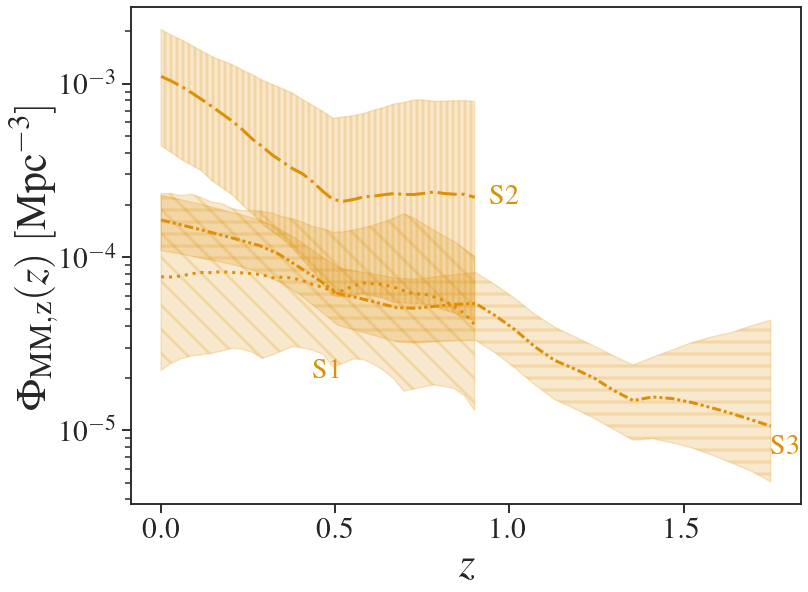

In [210]:
plt.figure(figsize=(12, 9))

plt.fill_between(z_range_borch, S1_detectable_gal_mr_density_q[0], S1_detectable_gal_mr_density_q[2],
                 color=cs[1], alpha=.2, hatch='\\')
s1, = plt.plot(z_range_borch, S1_detectable_gal_mr_density_q[1], color=cs[1],
                linewidth=3, linestyle=':')
plt.text(z_range_borch[int(n_mesh / 2) - 1], .9 * S1_detectable_gal_mr_density_q[0, int(n_mesh / 2) - 1], 'S1', color=cs[1],
           verticalalignment='top', horizontalalignment='left', fontsize=text_fs)

plt.fill_between(z_range_drory, S2_detectable_gal_mr_density_q[0], S2_detectable_gal_mr_density_q[2],
                 color=cs[1], alpha=.2, hatch='||')
s2, = plt.plot(z_range_drory, S2_detectable_gal_mr_density_q[1], color=cs[1],
                linewidth=3, linestyle='-.')
plt.text(1.05 * z_range_drory[n_mesh - 1], S2_detectable_gal_mr_density_q[1, n_mesh - 1], 'S2', color=cs[1],
           verticalalignment='center', horizontalalignment='left', fontsize=text_fs)

plt.fill_between(z_range_ilbert, S3_detectable_gal_mr_density_q[0], S3_detectable_gal_mr_density_q[2],
                 color=cs[1], alpha=.2, hatch='-')
s3, = plt.plot(z_range_ilbert, S3_detectable_gal_mr_density_q[1], color=cs[1],
                linewidth=3, linestyle=(0, (3, 1, 1, 1, 1, 1)))
# plt.text(1.05 * z_range_ilbert[n_mesh - 1], S3_detectable_gal_mr_density_q[1, n_mesh - 1], 'S3', color=cs[1],
#            verticalalignment='center', horizontalalignment='left', fontsize=text_fs)
plt.text(z_range_ilbert[n_mesh - 1], .9 * S3_detectable_gal_mr_density_q[1, n_mesh - 1], 'S3', color=cs[1],
           verticalalignment='top', horizontalalignment='left', fontsize=text_fs)

plt.yscale('log')
plt.ylabel(r'$\Phi_{\rm{MM}, z}(z)\ [\rm{Mpc}^{-3}]$', fontsize=label_fsize)
plt.xlabel(r'$z$', fontsize=label_fsize)
# plt.set_ylim(top=5e-2, bottom=1e-7)

# plt.legend([(s1, s2, s3)], ['S13 Models'], numpoints=1,
#              handler_map={tuple: HandlerTupleVertical(ndivide=None)}, loc='lower right', frameon=False, fontsize=legend_fsize)

# plt.text(.95, .95, '(a)', fontsize=legend_fsize, verticalalignment='top', horizontalalignment='right', transform=ax[0, 0].transAxes)


plt.tight_layout()
plt.savefig('../reports/figures/S13_gal_merger_rates.pdf')
plt.savefig('../reports/figures/S13_gal_merger_rates.png')
plt.show()